# Protéome et la loi de Benford
Ce notebook à pour objectif d'explorer le protéome de _Saccharomyces cerevisiae_ et de vérifier si la loi de Benford est présente pour ce type de données.  

Ici nous allons analyser si, la masse des peptides issue d'une digestion, la taille des pepetides issue d'une digestion, le nombre de site de clivage par protéine du protéome et le nombre d'acide aminé par protéines du protéome suit la loi de Benford pour le premier et le deux premiers digit.

Les peptides ont été obtenues après digestion à par la trypsin du protéome de _Saccharomyces cerevisiae_. Cette digestion est réalisée à l'aide du module [pyteomics](https://pyteomics.readthedocs.io/en/latest/).

In [1]:
import os
from urllib.request import urlretrieve
import gzip
import numpy as np
from pyteomics import fasta, parser, mass

import pybenford as ben

## Acqusition de l'archive du fichier fasta de _Saccharomyces cerevisiae_

In [2]:
if not os.path.isfile('yeast.fasta.gz'):
    print('Downloading the FASTA file for Saccharomyces cerevisiae...')
    try:
        urlretrieve(
            'ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/'
            'reference_proteomes/Eukaryota/UP000002311/UP000002311_559292.fasta.gz',
            'yeast.fasta.gz')
    except:
        print("Unable to download the file!")
    print('Done!')

## clivage des protéines du fichier fasta en peptides

In [3]:
%%time
print('Cleaving the proteins with trypsin...')
unique_peptides = set()
with gzip.open('yeast.fasta.gz', mode='rt') as gzfile:
    for description, sequence in fasta.FASTA(gzfile):
        new_peptides = parser.cleave(sequence, 'trypsin', missed_cleavages=1)
        unique_peptides.update(new_peptides)
print('Done, {0} sequences obtained!'.format(len(unique_peptides)))

Cleaving the proteins with trypsin...
Done, 471215 sequences obtained!
CPU times: user 976 ms, sys: 23.9 ms, total: 999 ms
Wall time: 998 ms


In [4]:
peptides = [{'sequence': i} for i in unique_peptides]

In [5]:
%%time
print('Parsing peptide sequences...')
for peptide in peptides:
    peptide['parsed_sequence'] = parser.parse(
         peptide['sequence'],
        show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence'])
print('Done!')

Parsing peptide sequences...
Done!
CPU times: user 6.53 s, sys: 47.7 ms, total: 6.58 s
Wall time: 6.57 s


In [6]:
%%time
print('Calculating the mass...')
pept_not_standard_id = []
i = 0
for peptide in peptides:
    try:
        peptide['mass'] = mass.calculate_mass(peptide['parsed_sequence'])
    except:
        pept_not_standard_id.append(i)
    i += 1
print('Done!')
print(f"Number of protiens that contain non-standard amino acid : {len(pept_not_standard_id)}")

Calculating the mass...
Done!
Number of protiens that contain non-standard amino acid : 0
CPU times: user 31.3 s, sys: 26.7 ms, total: 31.3 s
Wall time: 31.3 s


In [7]:
# Remove peptides that contains non-standard amino-acid
i = 0
for id_pept in pept_not_standard_id:
    del peptides[id_pept - i]
    i += 1
len(peptides)

471215

## Masse des peptides et la loi de Benford

In [8]:
print("Recovery of mass peptides...")
pept_mass = []
for peptide in peptides:
    pept_mass.append(peptide['mass'])
print("Done!")

Recovery of mass peptides...
Done!


### Tests statistiques pour le premier digit

In [9]:
first_digit = ben.count_first_digit(pept_mass)
freq_obs = ben.normalize_first_digit(first_digit)
freq_theo = ben.get_theoretical_freq_benford()

#### Histogramme de la fréquence observé et théorique

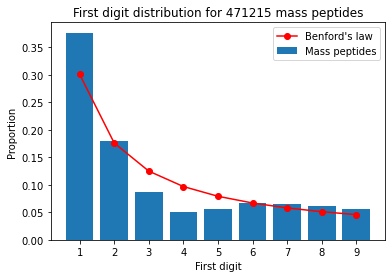

In [10]:
ben.build_hist_freq_ben(freq_obs, freq_theo, 1, title="First digit distribution for"
                        f" {sum(first_digit)} mass peptides", legend="Mass peptides")

On remarque graphiquement, que la masse des peptides ne semble pas suivre la loi de Benford pour le premier digit. 
#### Test bootstrap $\chi^2$

In [11]:
%%time
ben.calculate_bootstrap_chi2(pept_mass, freq_theo, 1)

statistics : 73.46140458280253 ; p-value : 1.002126317936551e-12
CPU times: user 28 s, sys: 28.3 ms, total: 28 s
Wall time: 28 s


(73.46140458280253, 1.002126317936551e-12)

Le test du $\chi^2$ par la méthode de "bootstrap", nous indique une p-value inférieur à 5%. On peut en conclure, pour un risque de 5%, que la masse des peptides après digestion par la trypsin du protéome de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour le premier digit.
#### Test de K-S

In [12]:
%%time
ben.calculate_bootstrap_ks(pept_mass, freq_theo, 1)

Not conform to Benford law, for alpha risk = 5%

CPU times: user 27.3 s, sys: 24.3 ms, total: 27.3 s
Wall time: 27.3 s


(0.083199117210521, 0.04300697617828996)

Le test de Kolmogorov-Smirnov par la méthode de "bootstrap", nous indique une valeur K-S = 0.0836 et une valeur critique de 0.043. On a donc une valeur de K-S supérieur à la valeur critique du test de K-S.  On peut en conclure, pour un risque de 5%, que la masse des peptides après digestion par la trypsin du protéome de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour le premier digit
#### Résultats

La masse des peptides après digestion par la trypsin du protéome de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour le premier digit, pour un risque alpha de 5%.

### Tests statistiques pour les 2 premiers digit

In [13]:
first_digit2 = ben.count_first_digit(pept_mass, 2)
freq_obs2 = ben.normalize_first_digit(first_digit2)
freq_theo2 = ben.get_theoretical_freq_benford(2)

#### Histogramme de la fréquence observé et théorique

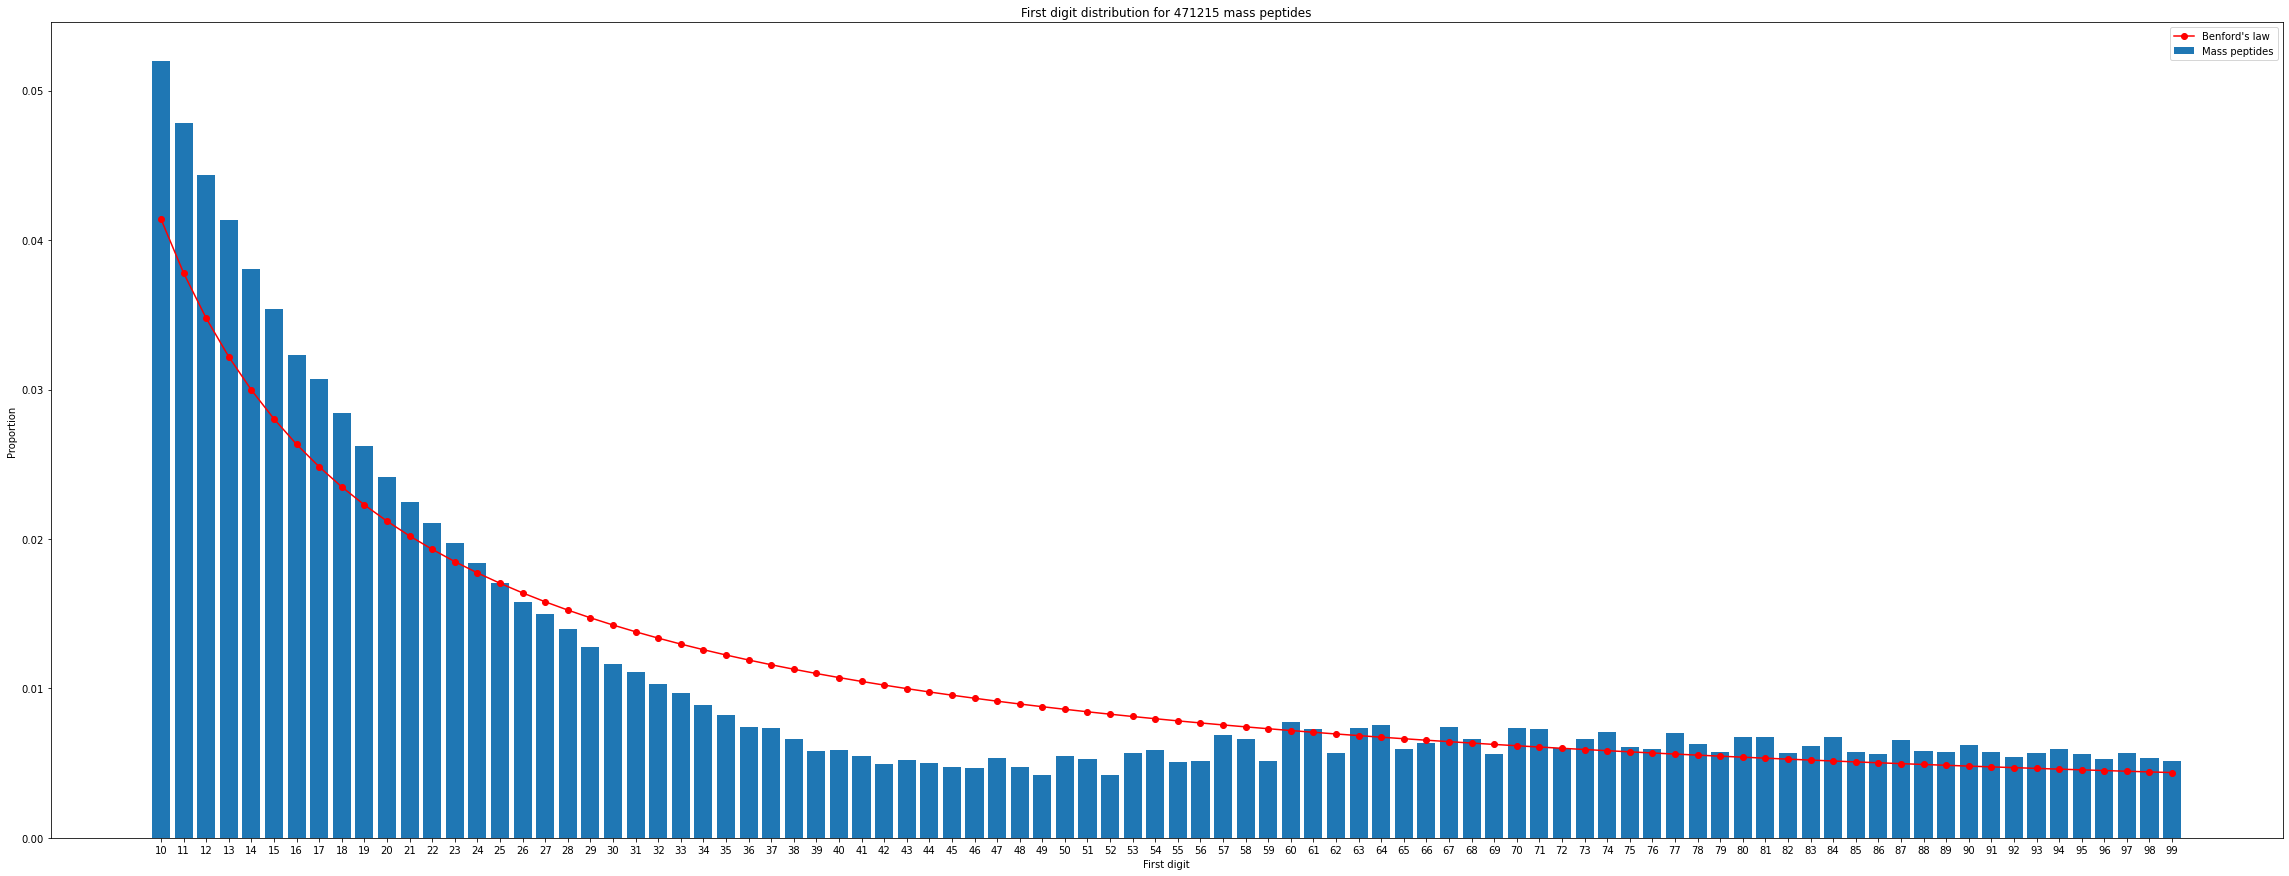

In [14]:
ben.build_hist_freq_ben(freq_obs2, freq_theo2, 2, size=(40, 15), title="First digit distribution for"
                        f" {sum(first_digit2)} mass peptides", legend="Mass peptides")

On remarque graphiquement, que la masse des peptides ne semble pas suivre la loi de Benford pour les 2 premiers digit. 
#### Test bootstrap $\chi^2$

In [15]:
%%time
ben.calculate_bootstrap_chi2(pept_mass, freq_theo2, 2)

statistics : 156.47115899486508 ; p-value : 1.3273783914672248e-05
CPU times: user 28.2 s, sys: 24.4 ms, total: 28.2 s
Wall time: 28.2 s


(156.47115899486508, 1.3273783914672248e-05)

Le test du $\chi^2$ par la méthode de "bootstrap", nous indique une p-value inférieur à 5%. On peut en conclure, pour un risque de 5%, que la masse des peptides après digestion par la trypsin du protéome de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour les 2 premiers digit.
#### Test de K-S

In [16]:
%%time
ben.calculate_bootstrap_ks(pept_mass, freq_theo2, 2)

Not conform to Benford law, for alpha risk = 5%

CPU times: user 27.7 s, sys: 22.3 ms, total: 27.7 s
Wall time: 27.7 s


(0.09048986796701737, 0.04300697617828996)

Le test de Kolmogorov-Smirnov par la méthode de "bootstrap", nous indique une valeur de K-S = 0.090 et une valeur critique de 0.043. On a donc une valeur de K-S supérieur à la valeur critique du test de K-S.  On peut en conclure, pour un risque de 5%, que la masse des peptides après digestion par la trypsin du protéome de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour les 2 premiers digit
### Résultats

La masse des peptides après digestion par la trypsin du protéome de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour les premiers digit, pour un risque alpha de 5%.

## Conclusion

La masse des peptides issues de la digestion d'un protéome par la trypsin ne suit pas la loi de Benford.  

Nous allons maintenant, analyser le nombre de site de clivage par la trypsin que possède chaque protéines du protéome de _Saccharomyces cerevisiae_.

## Nombre de site de clivage par protéines et la loi de Benford

In [17]:
%%time
print('Cleaving the proteins with trypsin...')
num_sites = []
with gzip.open('yeast.fasta.gz', mode='rt') as gzfile:
    for description, sequence in fasta.FASTA(gzfile):
        num_sites.append(parser.num_sites(sequence, 'trypsin'))
print('Done, {0} sequences obtained!'.format(len(num_sites)))

Cleaving the proteins with trypsin...
Done, 6050 sequences obtained!
CPU times: user 660 ms, sys: 4.51 ms, total: 665 ms
Wall time: 664 ms


In [18]:
print(f"Minium of cleavage site {min(num_sites)}")
print(f"Maximum of cleavage site {max(num_sites)}")
print(f"Mean of cleavage site {np.mean(num_sites)}")

Minium of cleavage site 0
Maximum of cleavage site 551
Mean of cleavage site 54.786115702479336


### Tests statistiques pour le premier digit

In [19]:
first_digit3 = ben.count_first_digit(num_sites)
freq_obs3 = ben.normalize_first_digit(first_digit3)

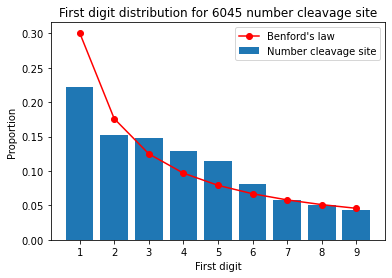

In [20]:
ben.build_hist_freq_ben(freq_obs3, freq_theo, 1, title="First digit distribution for"
                        f" {sum(first_digit3)} number cleavage site", legend="Number cleavage site")

In [21]:
ben.calculate_bootstrap_chi2(num_sites, freq_theo, 1)

statistics : 63.363984014309665 ; p-value : 1.0155537291138504e-10


(63.363984014309665, 1.0155537291138504e-10)

In [22]:
ben.calculate_bootstrap_ks(num_sites, freq_theo, 1)

Not conform to Benford law, for alpha risk = 5%



(0.10129114543810586, 0.04300697617828996)

On remarque graphiquement, que le nombre de site de clivage par protéine ne semble pas suivre la loi de Benford pour le premier digit.

Le test du $\chi^2$ par la méthode de "bootstrap", nous indique une p-value inférieur à 5%. On peut en conclure, pour un risque de 5%, que le nombre de site de clivage par protéine du protéome de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour le premier digit.

Le test de Kolmogorov-Smirnov par la méthode de "bootstrap", nous indique une valeur de K-S = 0.101 et une valeur critique de 0.043. On a donc une valeur de K-S supérieur à la valeur critique du test de K-S.  On peut en conclure, pour un risque de 5%, que le nombre de site de clivage par protéine du protéome de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour le premier digit.

### Résultats

Le nombre de site de clivage par protéine du protéome de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour le premier digit, pour un risque alpha de 5%.
    
    
### Tests statistiques pour les 2 premiers digit

In [23]:
first_digit4 = ben.count_first_digit(num_sites, 2)
freq_obs4 = ben.normalize_first_digit(first_digit4)

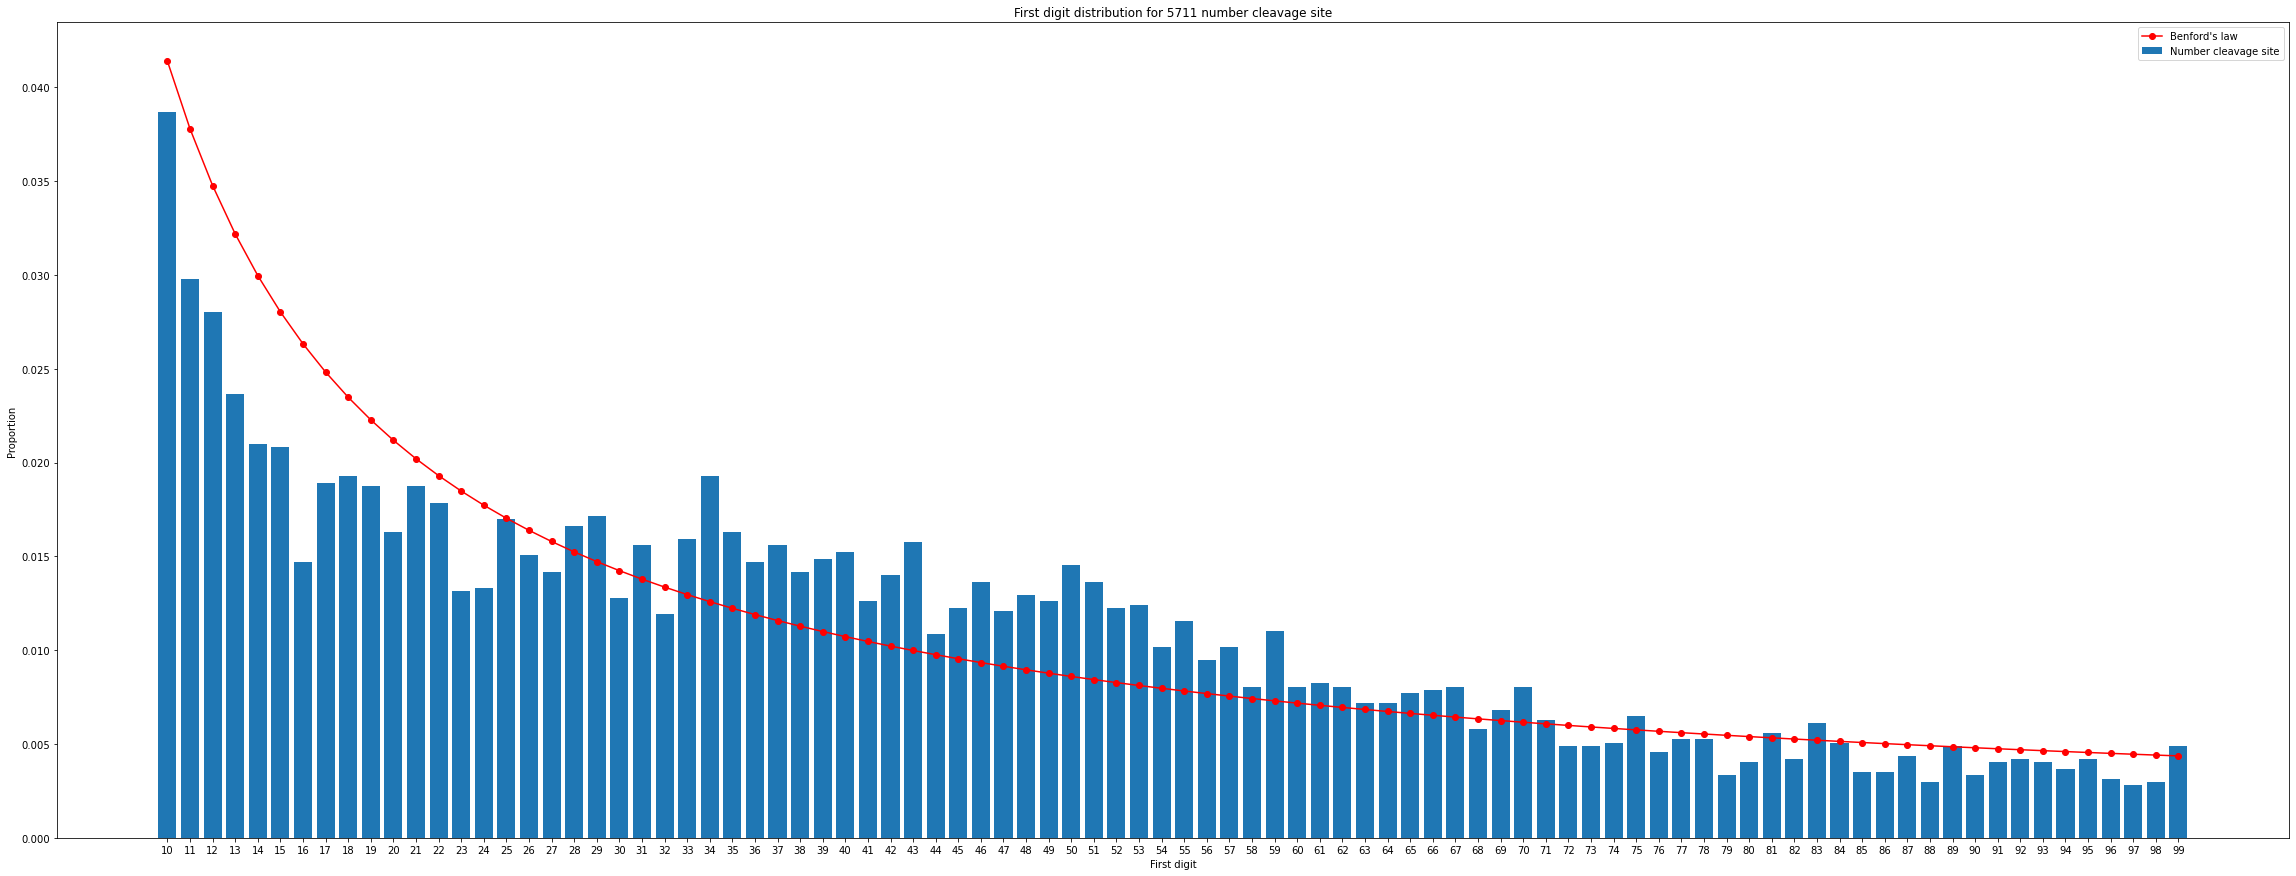

In [24]:
ben.build_hist_freq_ben(freq_obs4, freq_theo2, 2, size=(40, 15), title="First digit distribution for"
                        f" {sum(first_digit4)} number cleavage site", legend="Number cleavage site")

In [25]:
ben.calculate_bootstrap_chi2(num_sites, freq_theo2, 2)

statistics : 141.39067480241977 ; p-value : 0.00034494755809391084


(141.39067480241977, 0.00034494755809391084)

In [26]:
ben.calculate_bootstrap_ks(num_sites, freq_theo2, 2)

Not conform to Benford law, for alpha risk = 5%



(0.09314190608179768, 0.04300697617828996)

On remarque graphiquement, que le nombre de site de clivage par protéine ne semble pas suivre la loi de Benford pour les 2 premiers digit.

Le test du $\chi^2$ par la méthode de "bootstrap", nous indique une p-value inférieur à 5%. On peut en conclure, pour un risque de 5%, que le nombre de site de clivage par protéine du protéome de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour les 2 premiers digit.

Le test de Kolmogorov-Smirnov par la méthode de "bootstrap", nous indique une valeur de K-S = 0.093 et une valeur critique de 0.043. On a donc une valeur de K-S supérieur à la valeur critique du test de K-S.  On peut en conclure, pour un risque de 5%, que le nombre de site de clivage par protéine du protéome de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour les 2 premiers digit.

### Résultats

Le nombre de site de clivage par protéine du protéome de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour les premiers digit, pour un risque alpha de 5%.

## Conclusion

Le nombre de site de clivage à la trypsin par protéine ne suit pas la loi de Benford.  

Nous allons maintenant, analyser la taille des peptides issues du clivage du protéome de _Saccharomyces cerevisiae_ par la trypsin.

## Taille des peptides et la loi de Benford

In [27]:
len_pept = []
for peptide in peptides:
    len_pept.append(peptide["length"])

In [28]:
print(f"Minimum of peptides length {min(len_pept)}")
print(f"Maximum of peptides length {max(len_pept)}")
print(f"Mean of peptides length {np.mean(len_pept)}")

Minimum of peptides length 1
Maximum of peptides length 796
Mean of peptides length 16.625020425920226


### Tests statistiques pour le premier digit

In [29]:
first_digit5 = ben.count_first_digit(len_pept)
freq_obs5 = ben.normalize_first_digit(first_digit5)

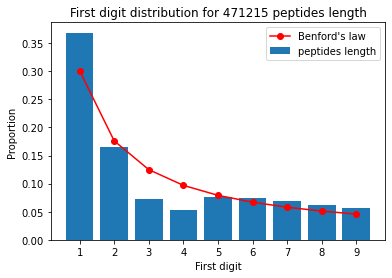

In [30]:
ben.build_hist_freq_ben(freq_obs5, freq_theo, 1, title="First digit distribution for"
                        f" {sum(first_digit5)} peptides length", legend="peptides length")

In [31]:
ben.calculate_bootstrap_chi2(len_pept, freq_theo, 1)

statistics : 74.47573836047721 ; p-value : 6.281080649898037e-13


(74.47573836047721, 6.281080649898037e-13)

In [32]:
ben.calculate_bootstrap_ks(len_pept, freq_theo, 1)

Not conform to Benford law, for alpha risk = 5%



(0.07061105521891058, 0.04300697617828996)

On remarque graphiquement, que la taille des peptides issues du clivage par la trypsin du protéome de _Saccharomyces cerevisiae_ ne semble pas suivre la loi de Benford pour le premier digit.

Le test du $\chi^2$ par la méthode de "bootstrap", nous indique une p-value inférieur à 5%. On peut en conclure, pour un risque de 5%, que la taille des peptides issues du clivage par la trypsin du protéome de _Saccharomyces cerevisiae_  ne suit pas la loi de Benford pour le premier digit.

Le test de Kolmogorov-Smirnov par la méthode de "bootstrap", nous indique une valeur de K-S = 0.071 et une valeur critique de 0.043. On a donc une valeur de K-S supérieur à la valeur critique du test de K-S.  On peut en conclure, pour un risque de 5%, que la taille des peptides issues du clivage par la trypsin du protéome de _Saccharomyces cerevisiae_  ne suit pas la loi de Benford pour le premier digit.

### Résultats

La taille des peptides issues du clivage par la trypsin du protéome de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour le premier digit, pour un risque alpha de 5%.
    
    
### Tests statistiques pour les 2 premiers digit

In [33]:
first_digit6 = ben.count_first_digit(len_pept, 2)
freq_obs6 = ben.normalize_first_digit(first_digit6)

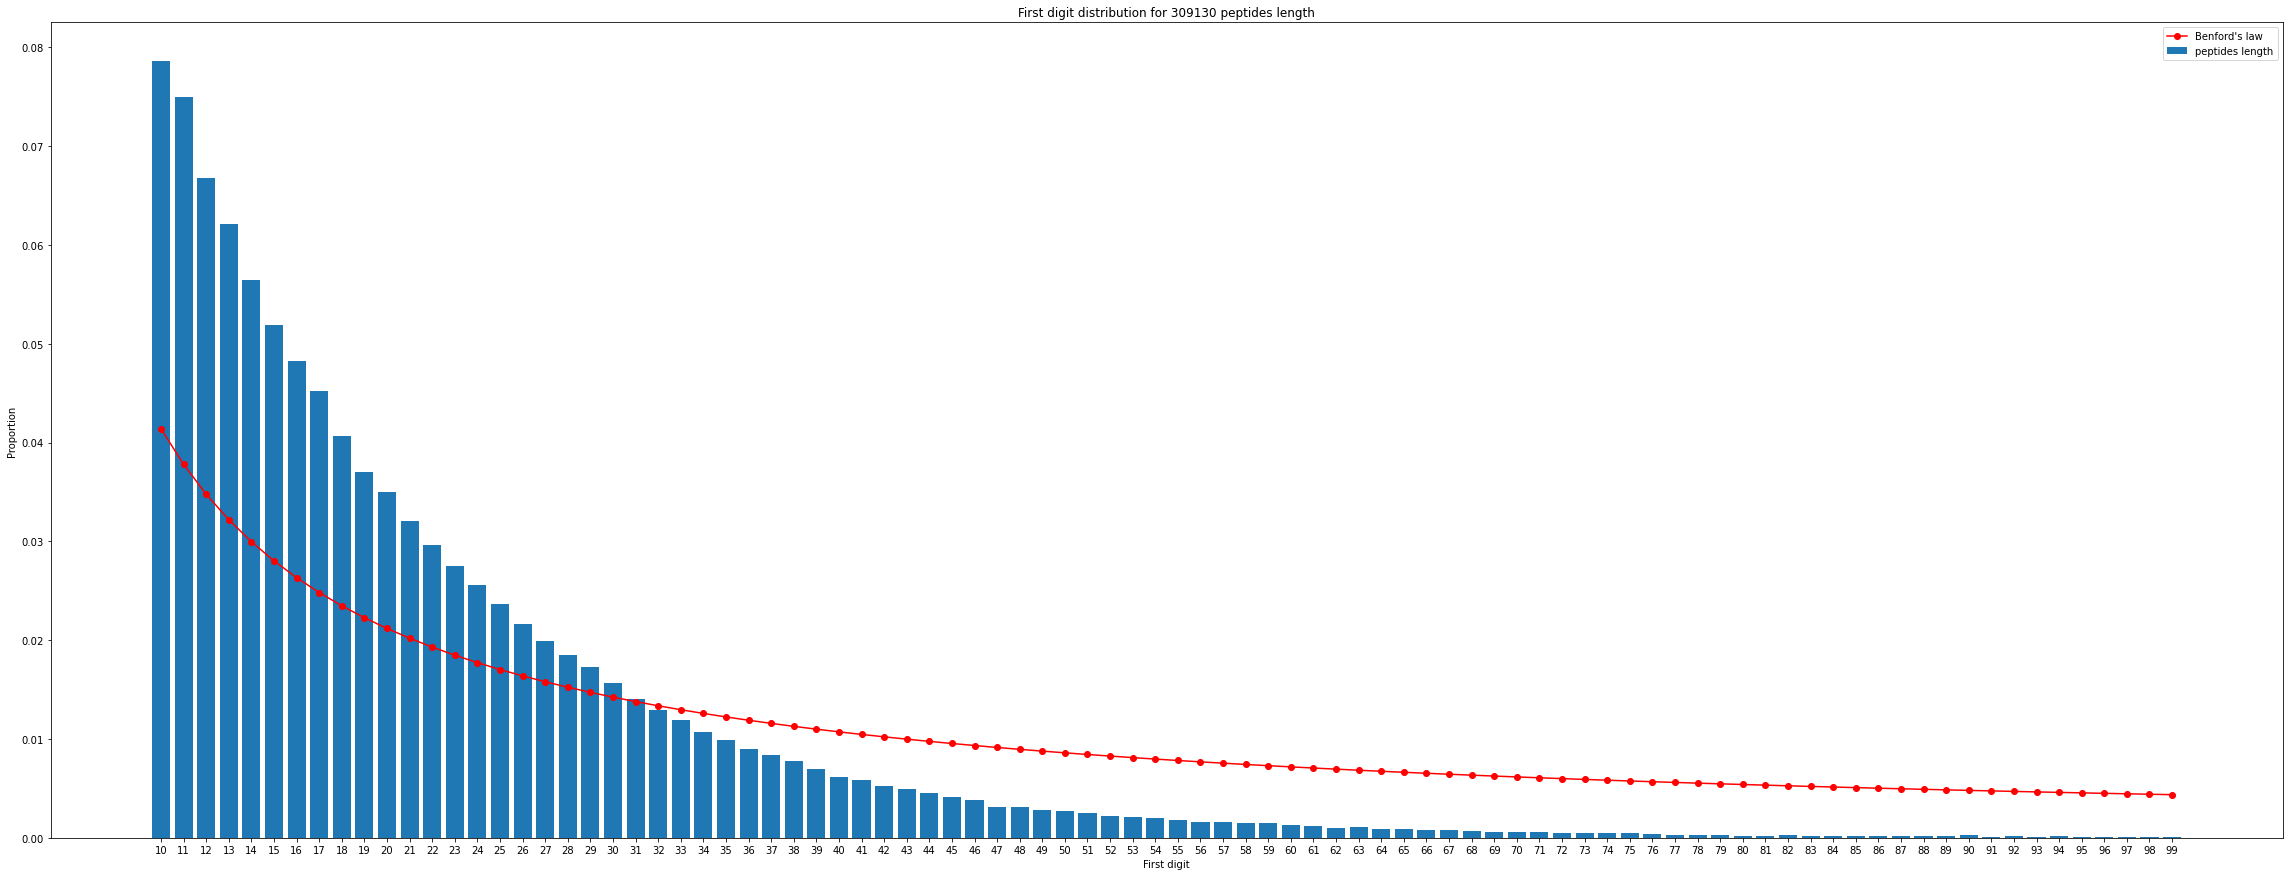

In [34]:
ben.build_hist_freq_ben(freq_obs6, freq_theo2, 2, size=(40, 15), title="First digit distribution for"
                        f" {sum(first_digit6)} peptides length", legend="peptides length")

In [35]:
ben.calculate_bootstrap_chi2(len_pept, freq_theo2, 2)

statistics : 381.58031576381006 ; p-value : 7.160769665663856e-38


(381.58031576381006, 7.160769665663856e-38)

In [36]:
ben.calculate_bootstrap_ks(len_pept, freq_theo2, 2)

Not conform to Benford law, for alpha risk = 5%



(0.34356424999814, 0.04300697617828996)

On remarque graphiquement, que la taille des peptides issues du clivage par la trypsin du protéome de _Saccharomyces cerevisiae_ ne semble pas suivre la loi de Benford pour les 2 premiers digit.

Le test du $\chi^2$ par la méthode de "bootstrap", nous indique une p-value inférieur à 5%. On peut en conclure, pour un risque de 5%, que la taille des peptides issues du clivage par la trypsin du protéome de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour les 2 premiers digit.

Le test de Kolmogorov-Smirnov par la méthode de "bootstrap", nous indique une valeur de K-S = 0.343 et une valeur critique de 0.043. On a donc une valeur de K-S supérieur à la valeur critique du test de K-S.  On peut en conclure, pour un risque de 5%, que la taille des peptides issues du clivage par la trypsin du protéome de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour les 2 premiers digit.

### Résultats

La taille des peptides issues du clivage par la trypsin du protéome de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour les premiers digit, pour un risque alpha de 5%.

## Conclusion

La taille des peptides issues du clivage par la trypsin d'un protéome ne suit pas la loi de Benford.

## Nombre Total d'acides aminés dans le protéomes

In [37]:
%%time
print('Cleaving the proteins with trypsin...')
proteins = []
with gzip.open('yeast.fasta.gz', mode='rt') as gzfile:
    for description, sequence in fasta.FASTA(gzfile):
        proteins.append(sequence)
print('Done, {0} sequences obtained!'.format(len(proteins)))

Cleaving the proteins with trypsin...
Done, 6050 sequences obtained!
CPU times: user 122 ms, sys: 6.67 ms, total: 128 ms
Wall time: 128 ms


In [38]:
%%time
dict_aa = {}

amino_acid = "GASVTEDRQNMLKICYWPHF"

for letter in amino_acid:
    list_aa = []
    for prot in proteins:
        nb_aa = 0
        for aa in prot:
            if aa == letter:
                nb_aa += 1
        list_aa.append(nb_aa)
    dict_aa[letter] = list_aa

CPU times: user 4.5 s, sys: 8.61 ms, total: 4.51 s
Wall time: 4.51 s


In [39]:
len(dict_aa.keys())

20

results boostrap chisquare test of amino acid G :
statistics : 49.13363130973849 ; p-value : 5.993583673000787e-08
results boostrap K-S test of amino acid G :
Not conform to Benford law, for alpha risk = 5%

results boostrap chisquare test of amino acid A :
statistics : 45.18441955217572 ; p-value : 3.3953370801504423e-07
results boostrap K-S test of amino acid A :
Not conform to Benford law, for alpha risk = 5%

results boostrap chisquare test of amino acid S :
statistics : 15.593080102368038 ; p-value : 0.04858881000306351
results boostrap K-S test of amino acid S :
Comform to Benford law, for alpha risk = 5%

results boostrap chisquare test of amino acid V :
statistics : 64.01311347184745 ; p-value : 7.561305930359956e-11
results boostrap K-S test of amino acid V :
Not conform to Benford law, for alpha risk = 5%

results boostrap chisquare test of amino acid T :
statistics : 38.44676308089049 ; p-value : 6.224146559910487e-06
results boostrap K-S test of amino acid T :
Not conform t

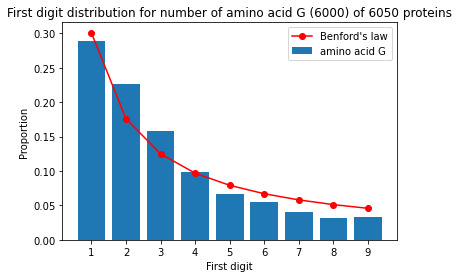

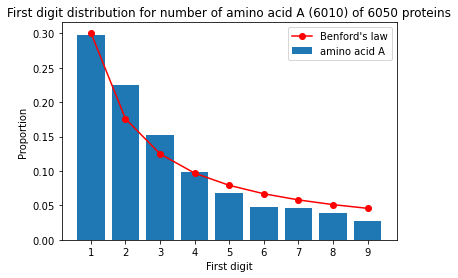

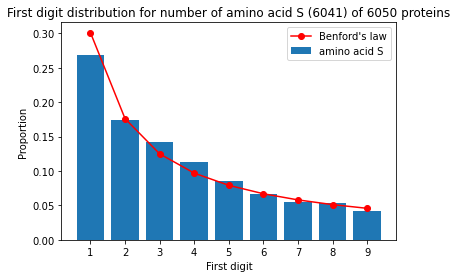

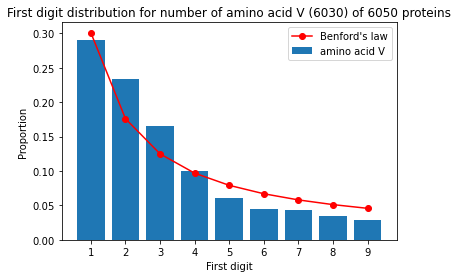

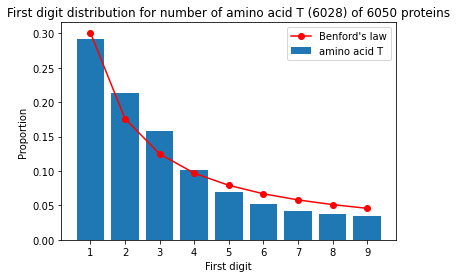

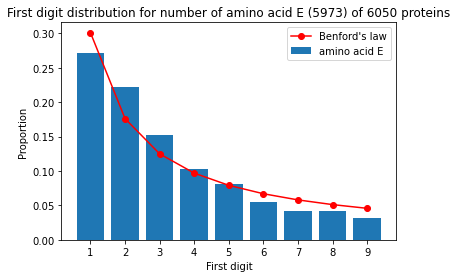

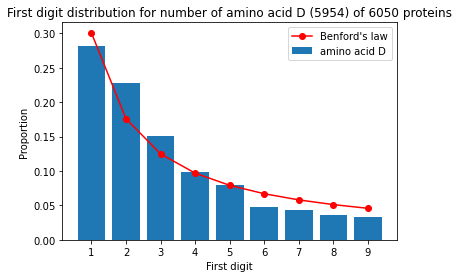

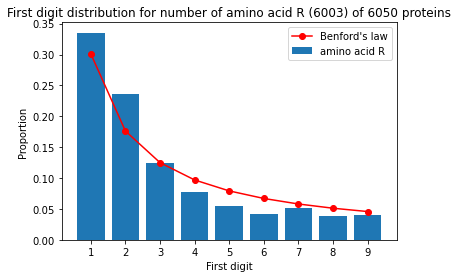

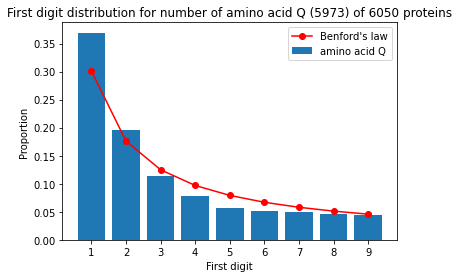

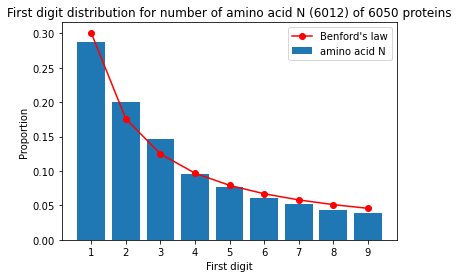

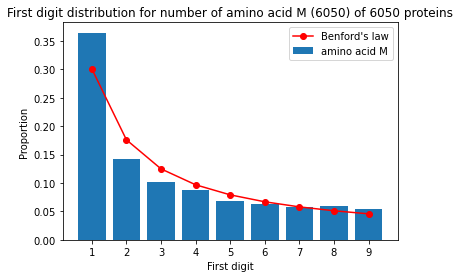

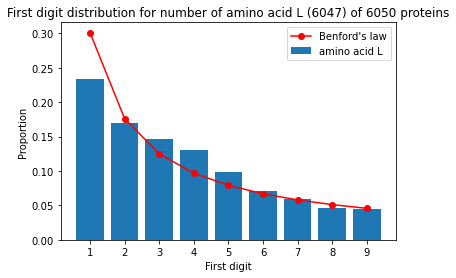

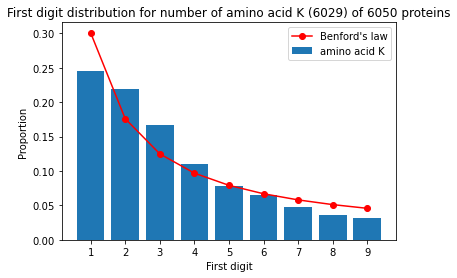

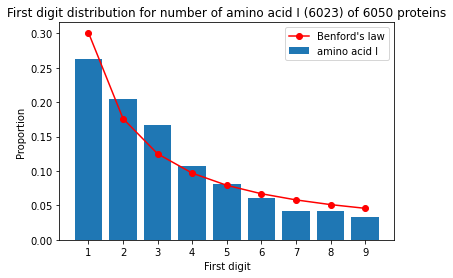

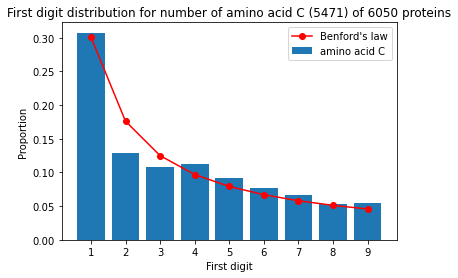

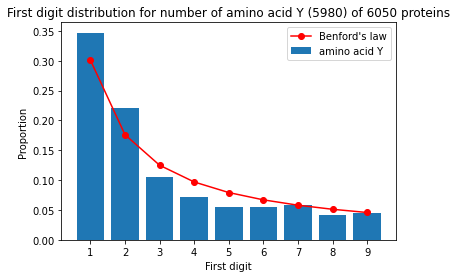

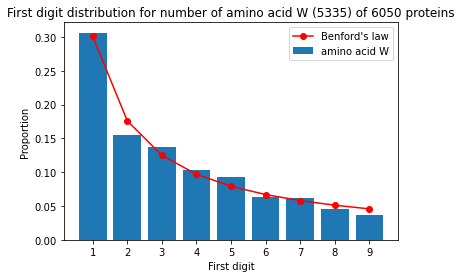

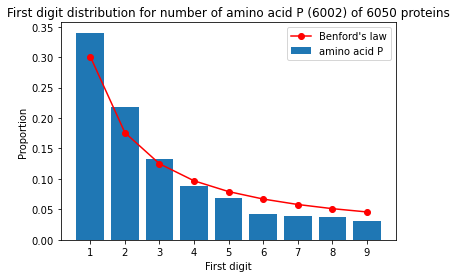

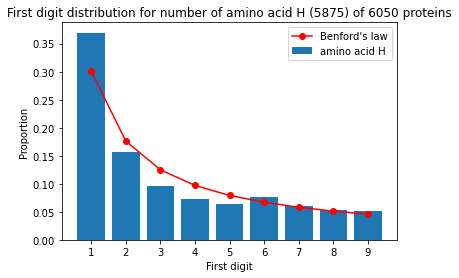

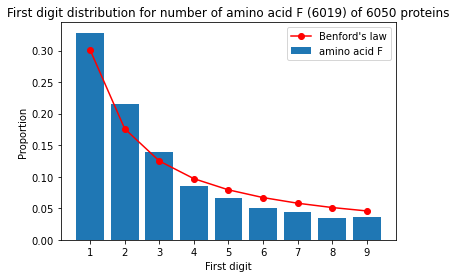

In [40]:
%%time
for aa in amino_acid:
    first_digit_aa = ben.count_first_digit(dict_aa[aa])
    freq_aa = ben.normalize_first_digit(first_digit_aa)

    ben.build_hist_freq_ben(freq_aa, freq_theo, 1, title="First digit distribution for"
                        f" number of amino acid {aa} ({sum(first_digit_aa)}) of "
                        f"{len(proteins)} proteins",
                            legend=f"amino acid {aa}")
    print(f"results boostrap chisquare test of amino acid {aa} :")
    ben.calculate_bootstrap_chi2(dict_aa[aa], freq_theo, 1)
    print(f"results boostrap K-S test of amino acid {aa} :")
    ben.calculate_bootstrap_ks(dict_aa[aa], freq_theo, 1)

On remarque graphiquement, que le nombre d'acide aminé par protéines du protéome de _Saccharomyces cerevisiae_ ne semble pas suivre la loi de Benford pour le premier digit.

Les tests du $\chi^2$ par la méthode de "bootstrap", nous indique une p-value inférieur à 5%, pour chacun des tests. On peut en conclure, pour un risque de 5%, que le nombre d'acide aminé par protéines du protéome de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour les 2 premiers digit.

Les tests de Kolmogorov-Smirnov par la méthode de "bootstrap", nous indique une valeur une valeur de K-S supérieur à la valeur critique du test de K-S, pour chacun des tests.  On peut en conclure, pour un risque de 5%, que le nombre d'acide aminé par protéines du protéome de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour les 2 premiers digit.

### Résultats

Le nombre d'acide aminé par protéines du protéome de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour les premiers digit, pour un risque alpha de 5%.

## Conclusion

Le nombre d'acide aminé par protéines d'un protéome ne suit pas la loi de Benford.

# Conclusion Générale

La masse et la longueur des peptides issues de la digestion par la trypsin du protéome de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour un rsque $\alpha$ de 5%.  
De même le nombre de site de clivage par la trypsin pour les protéines du protéomes de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour un risque $\alpha$ de 5%, tout comme le nombre d'acides aminés pour un AA donné (ex : l'Alaline).  
    
La même analyse à été réalisée pour le protéome humain dans le notebook : human_proteome_anlysis.ipynb

## Extra
### Nombre d'acide aminé par protéines et loi de benford pour les 2 premiers digit

results boostrap chisquare test of amino acid G :
statistics : 234.2389474704452 ; p-value : 5.220225028766709e-15
results boostrap K-S test of amino acid G :
Not conform to Benford law, for alpha risk = 5%

results boostrap chisquare test of amino acid A :
statistics : 208.9650454059953 ; p-value : 1.2012130767794393e-11
results boostrap K-S test of amino acid A :
Not conform to Benford law, for alpha risk = 5%

results boostrap chisquare test of amino acid S :
statistics : 110.65710604700082 ; p-value : 0.059774179042011266
results boostrap K-S test of amino acid S :
Not conform to Benford law, for alpha risk = 5%

results boostrap chisquare test of amino acid V :
statistics : 228.59512494717924 ; p-value : 3.0802889066450685e-14
results boostrap K-S test of amino acid V :
Not conform to Benford law, for alpha risk = 5%

results boostrap chisquare test of amino acid T :
statistics : 200.7528074428541 ; p-value : 1.3111064361496431e-10
results boostrap K-S test of amino acid T :
Not c

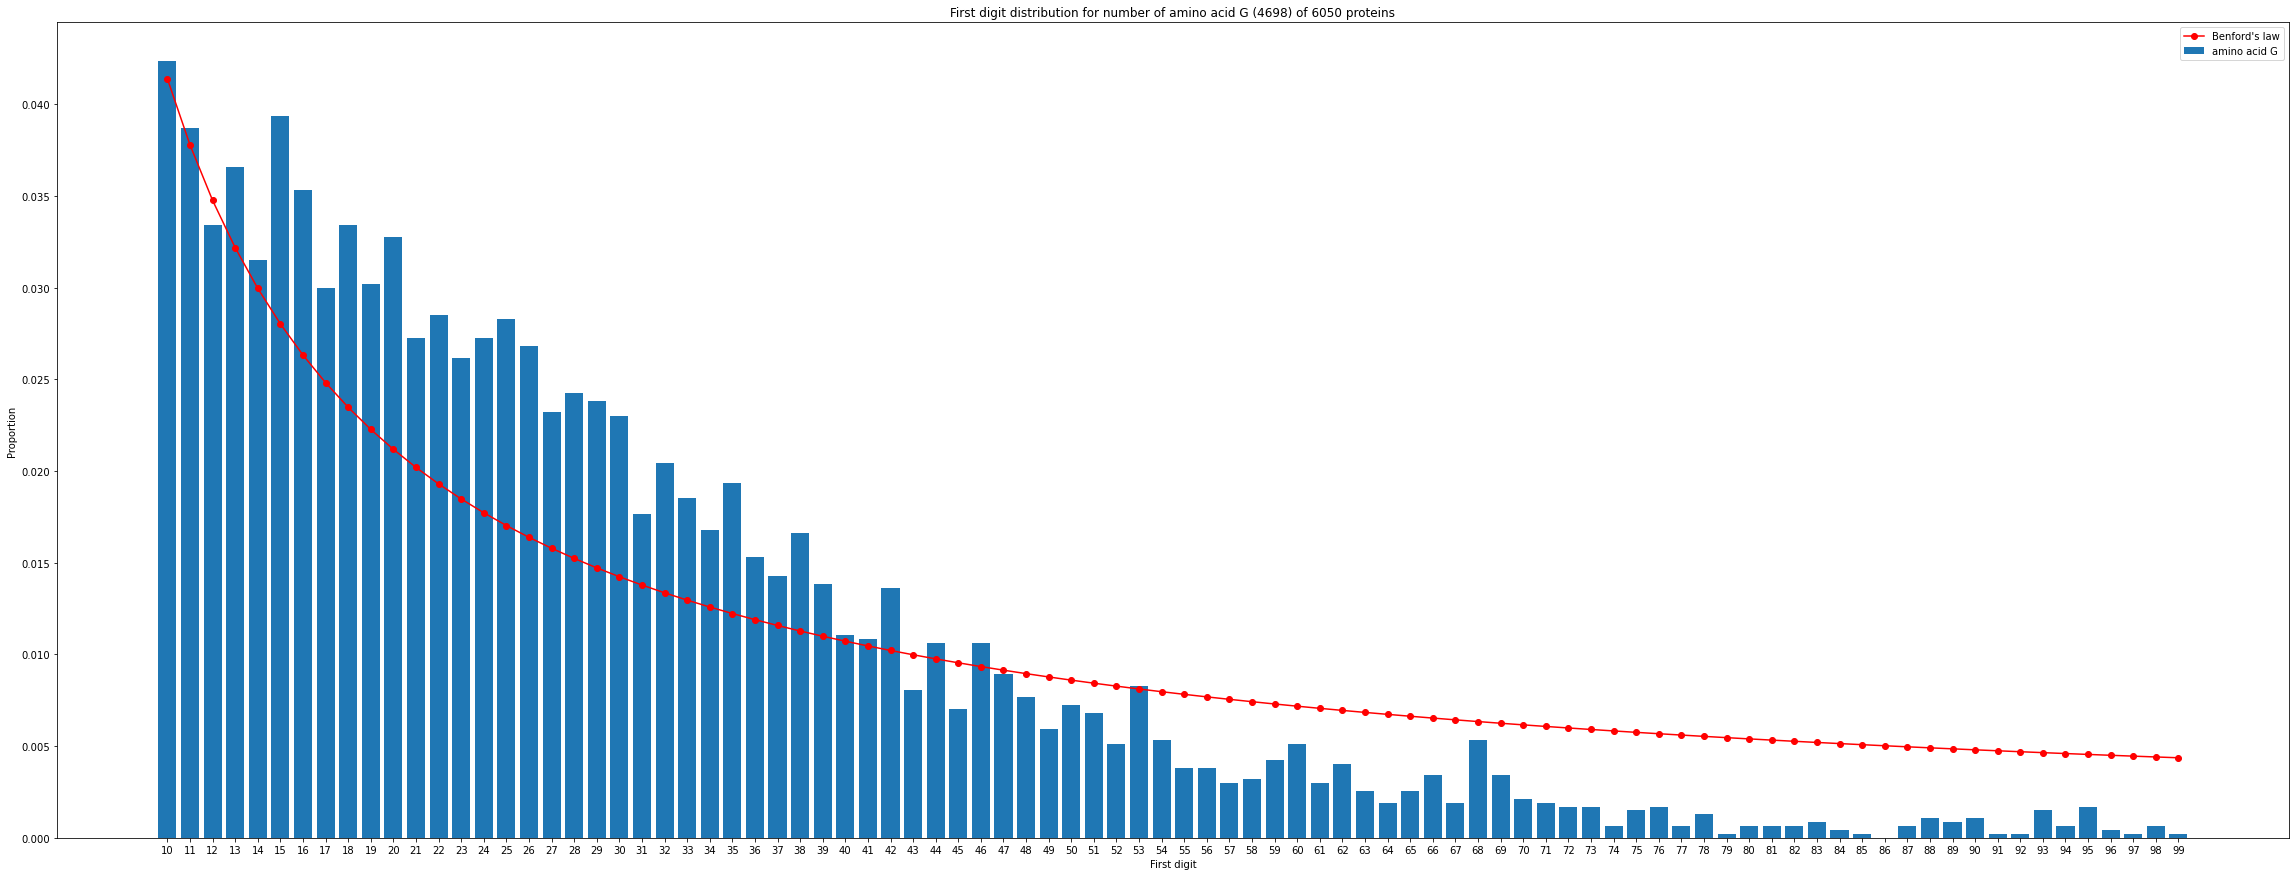

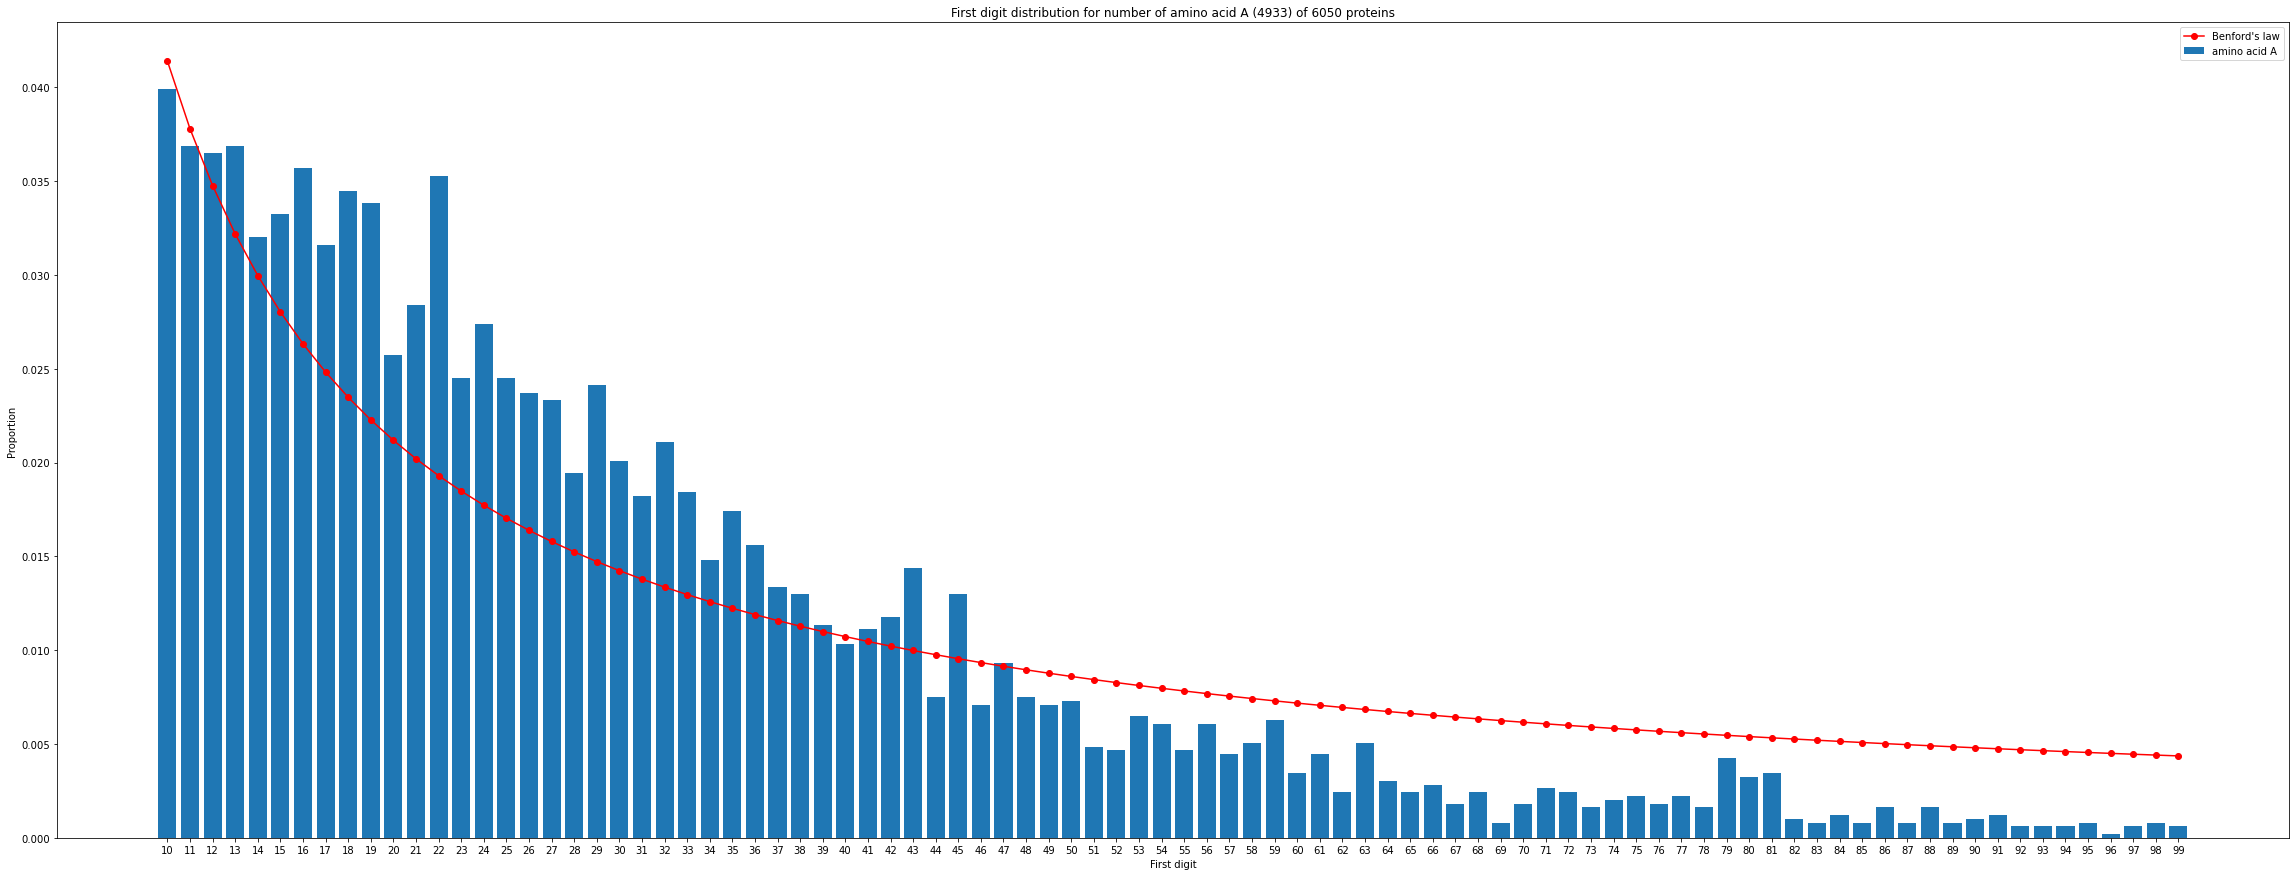

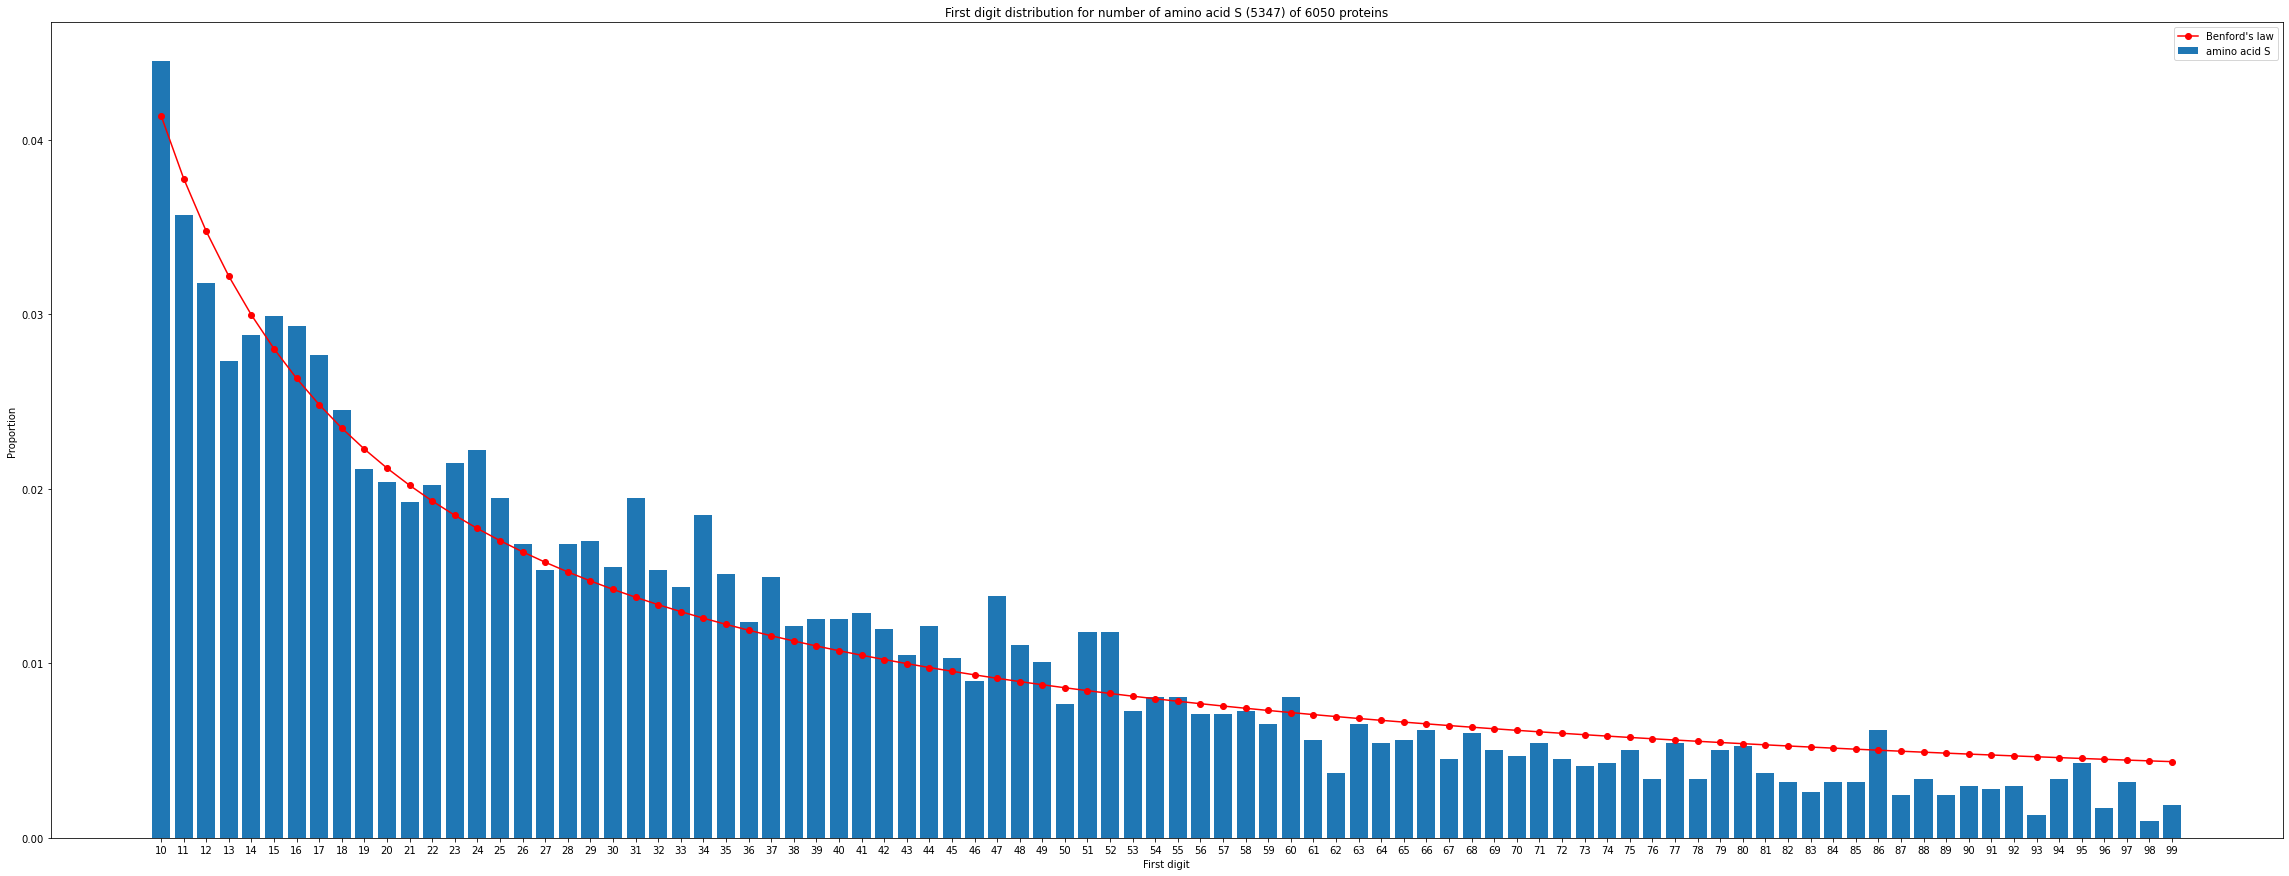

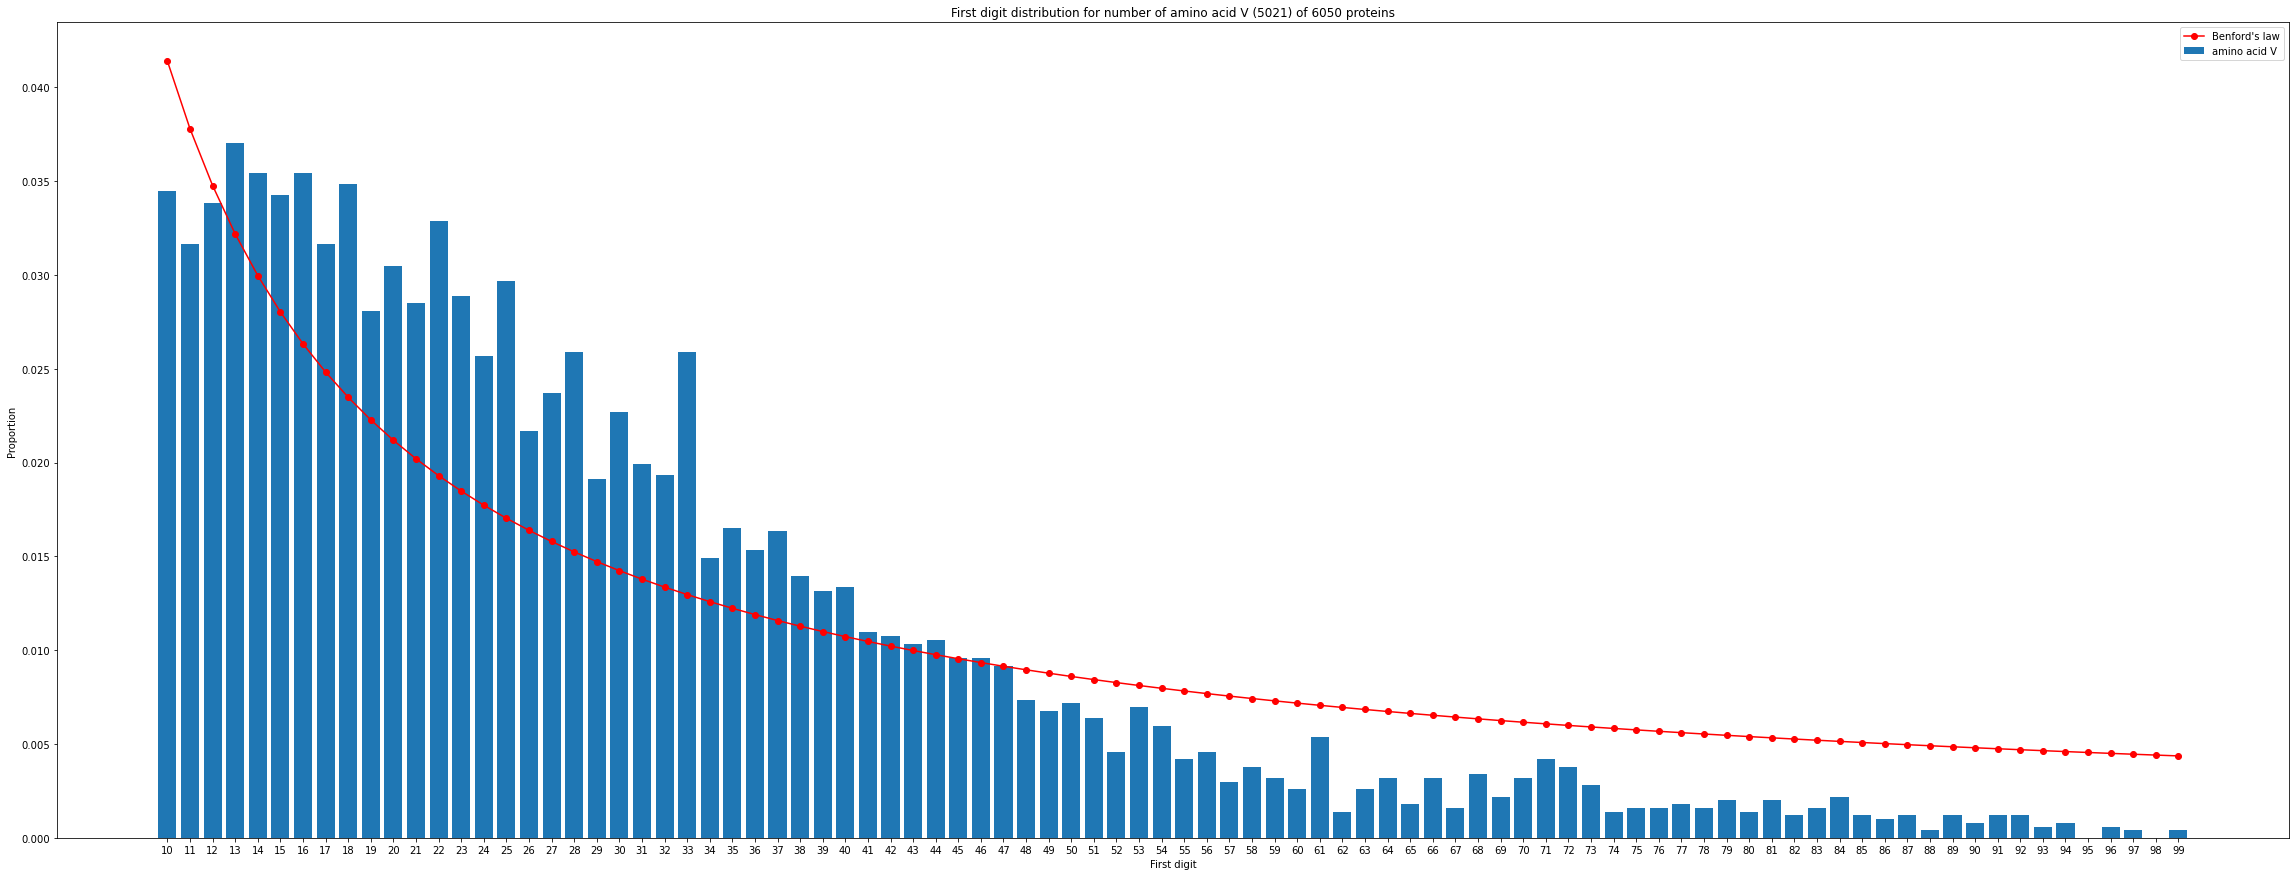

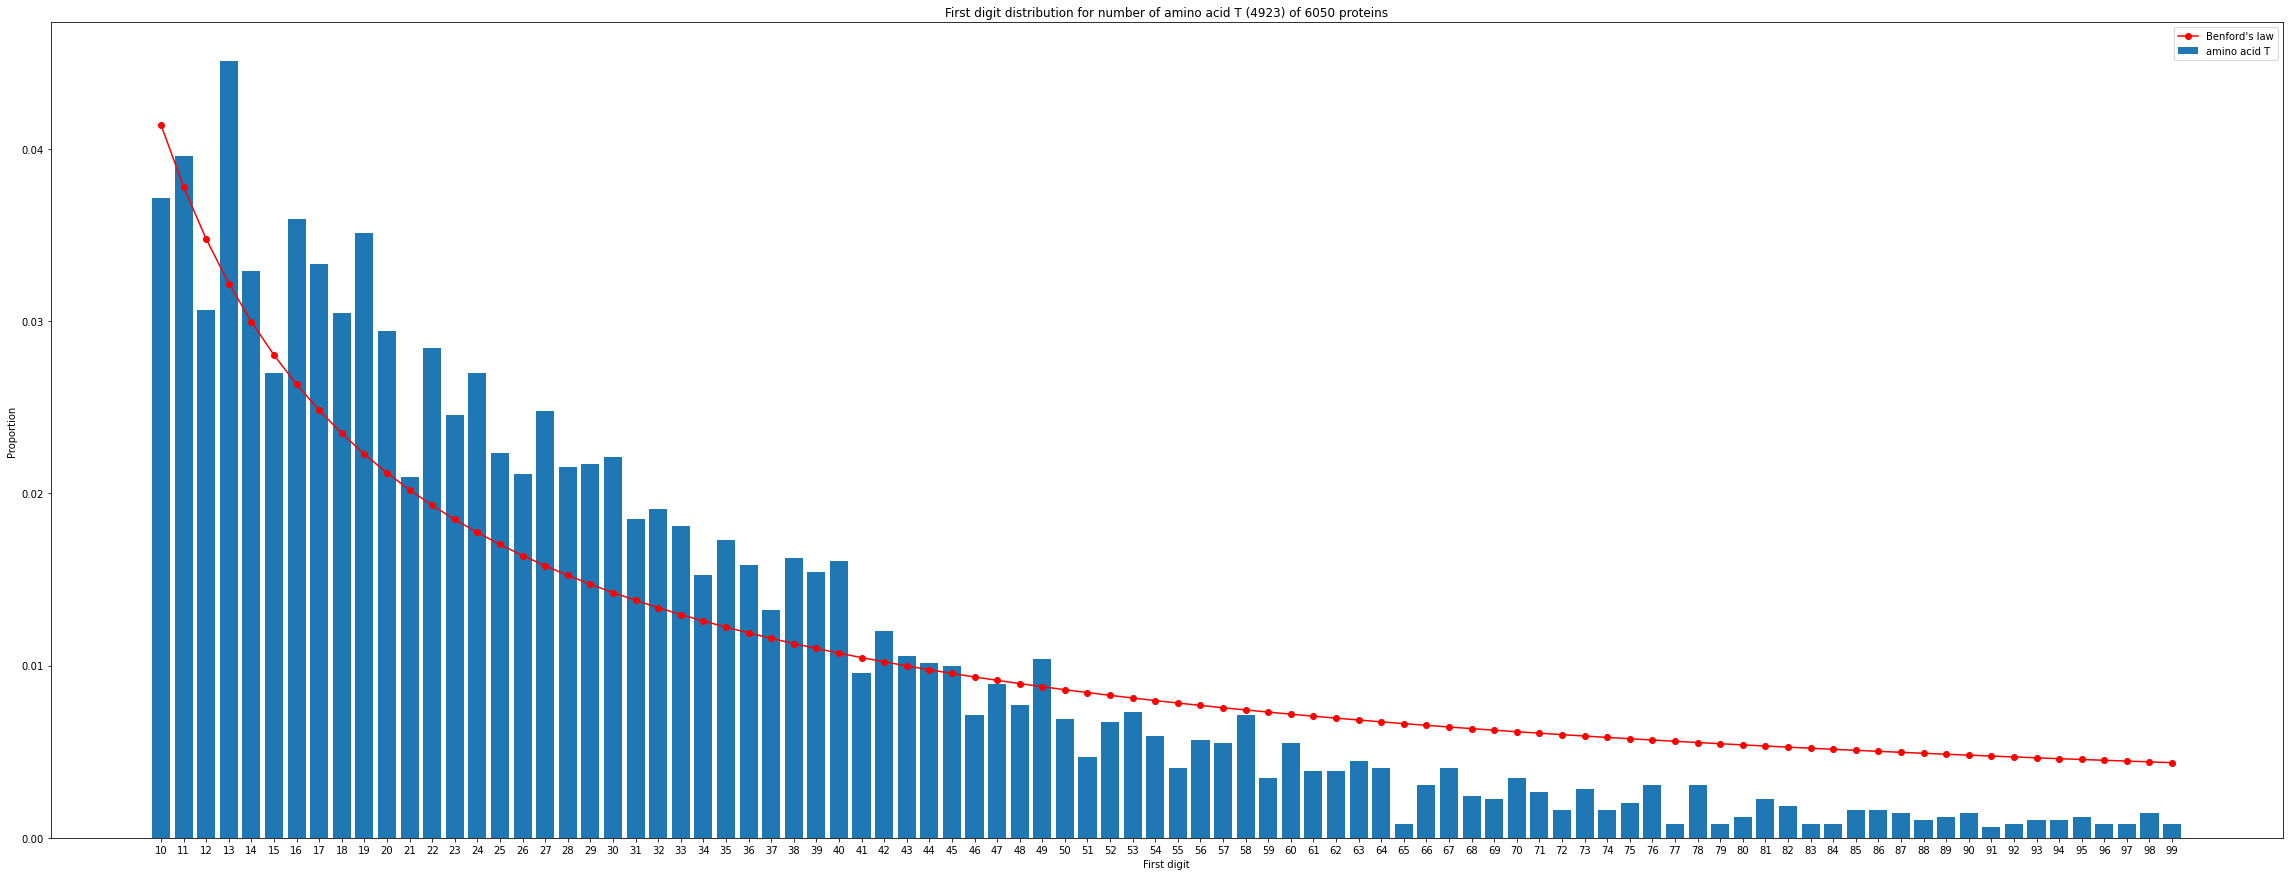

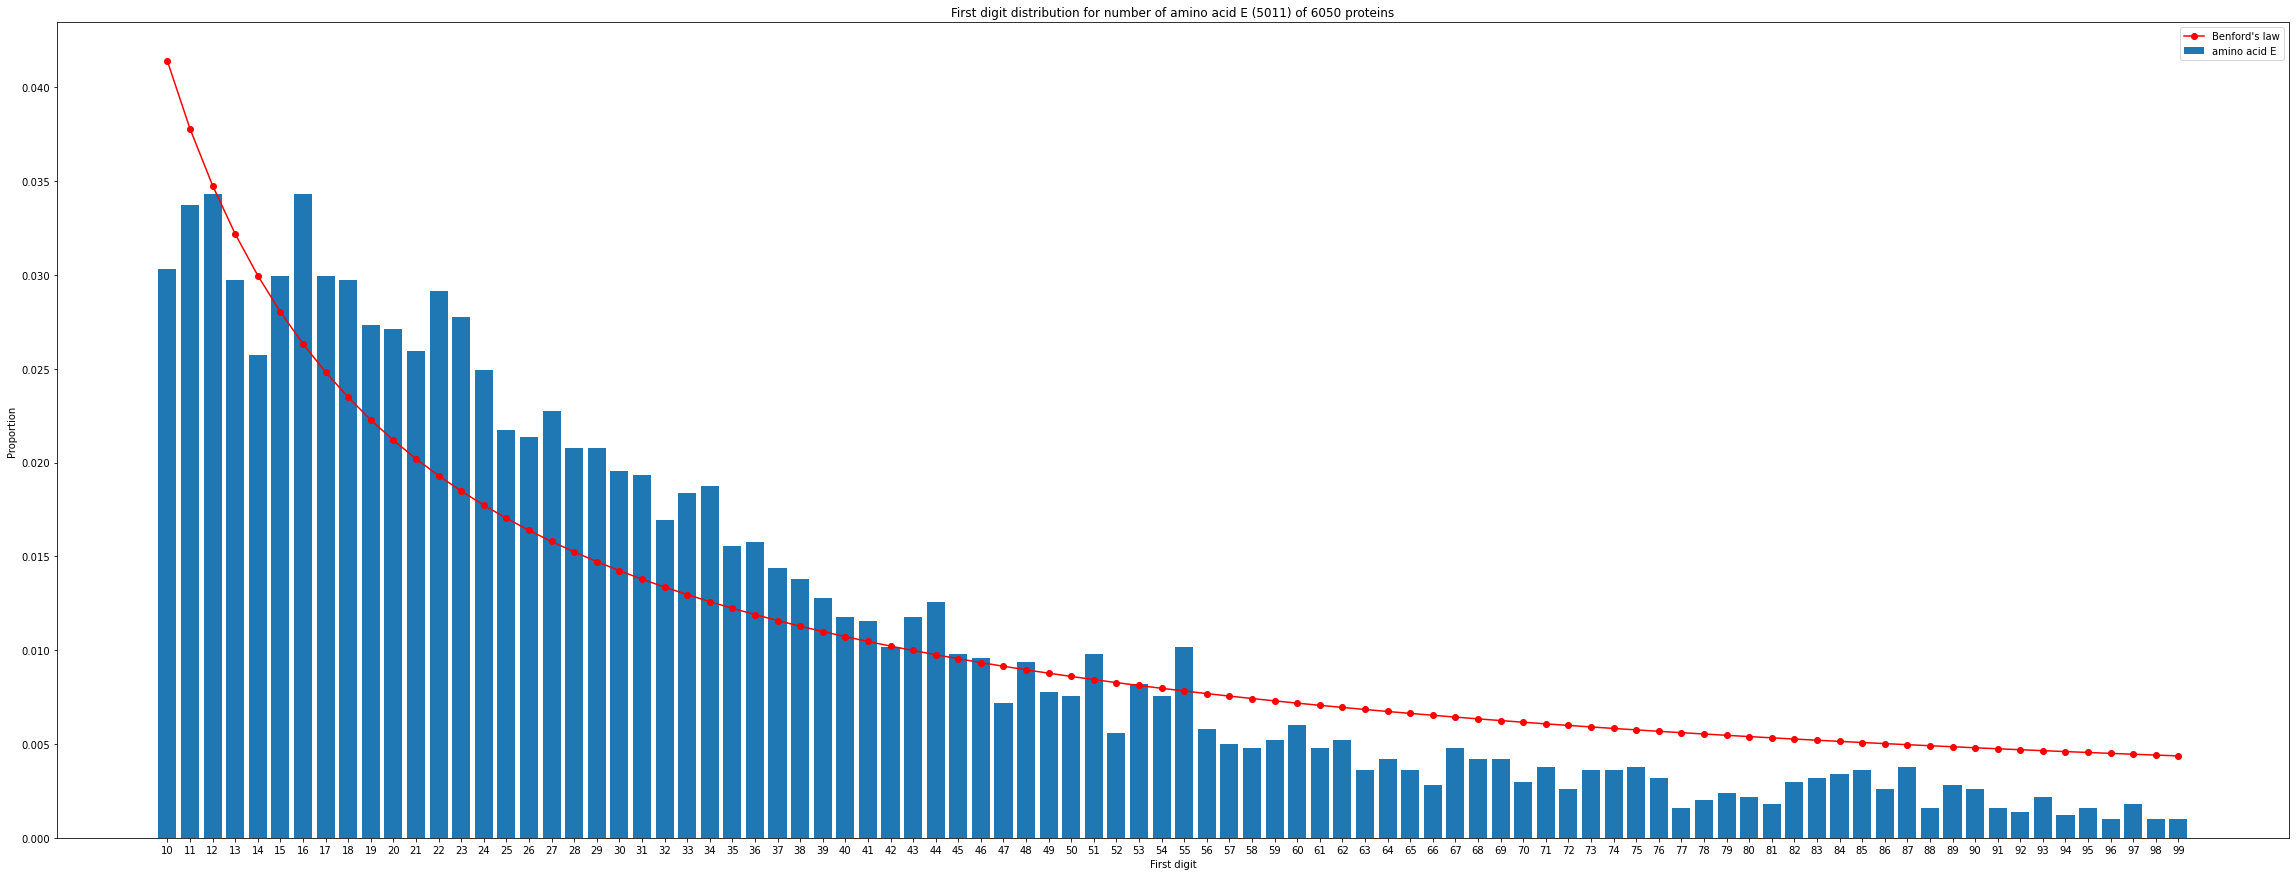

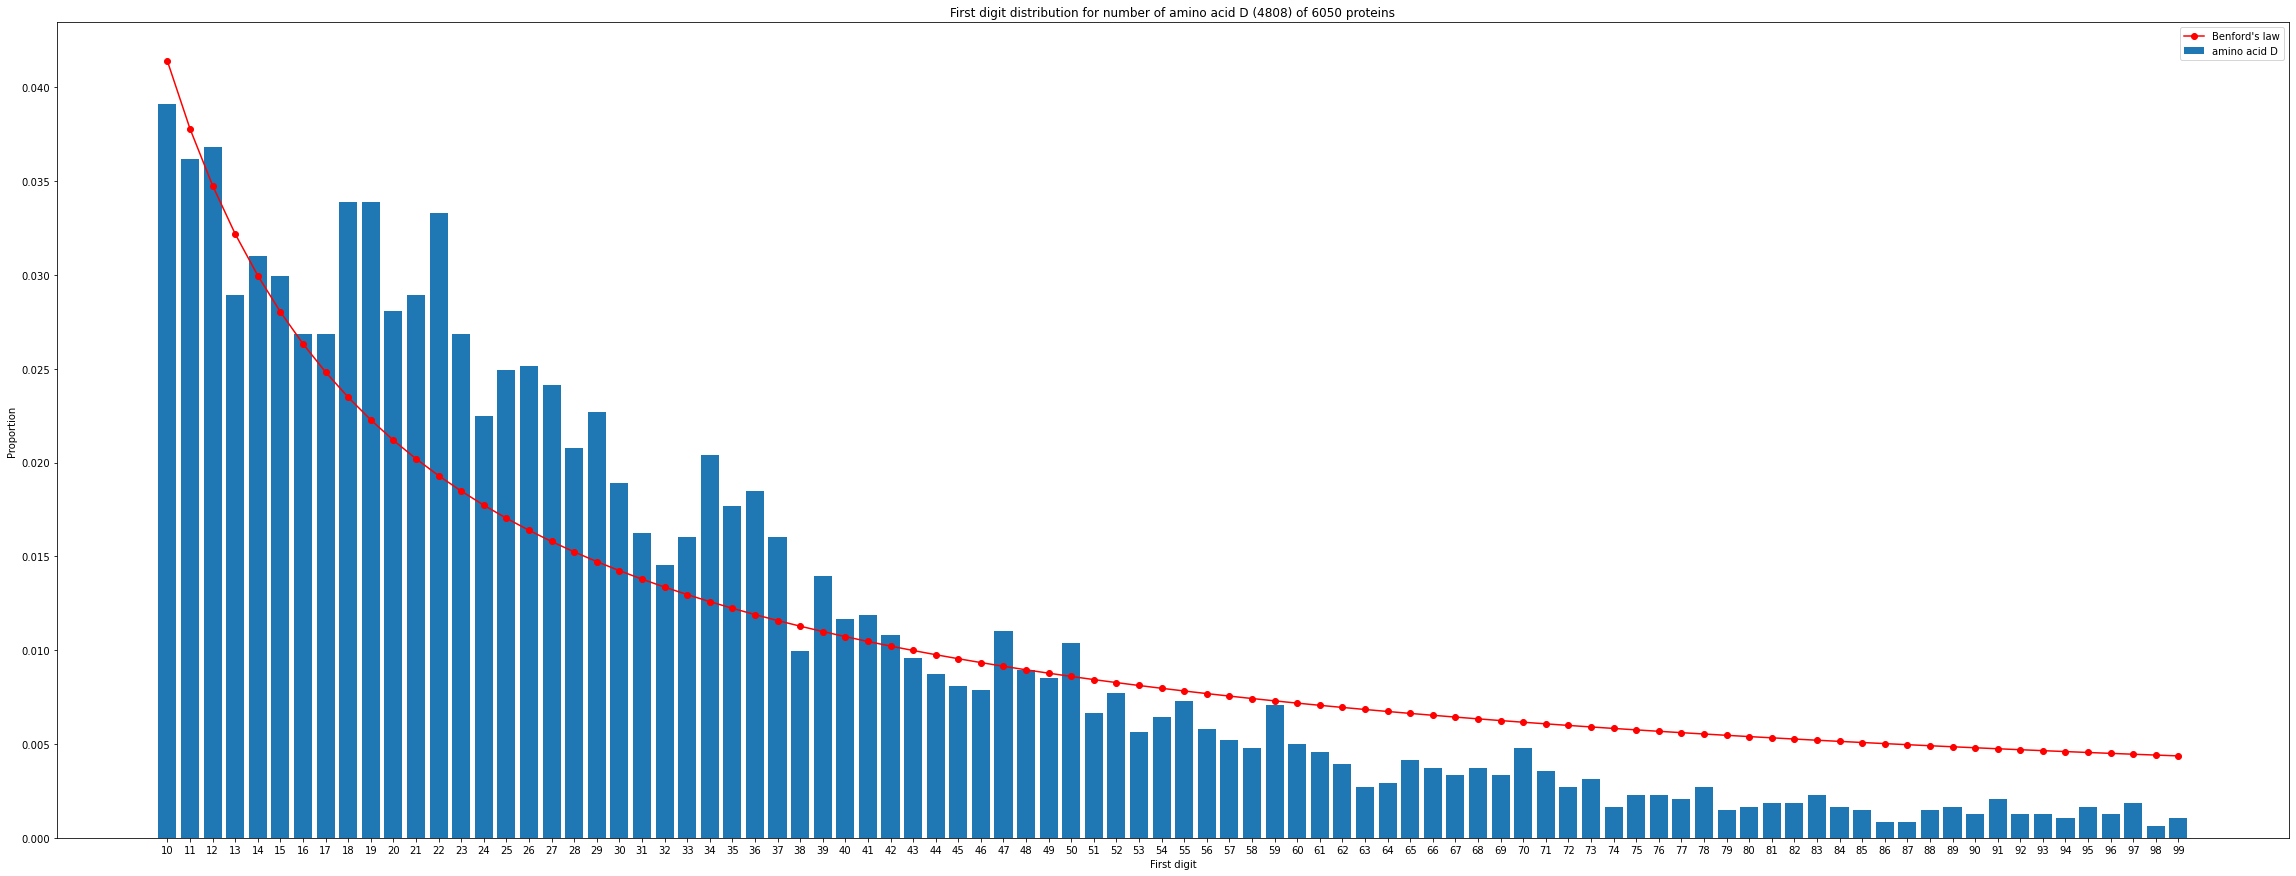

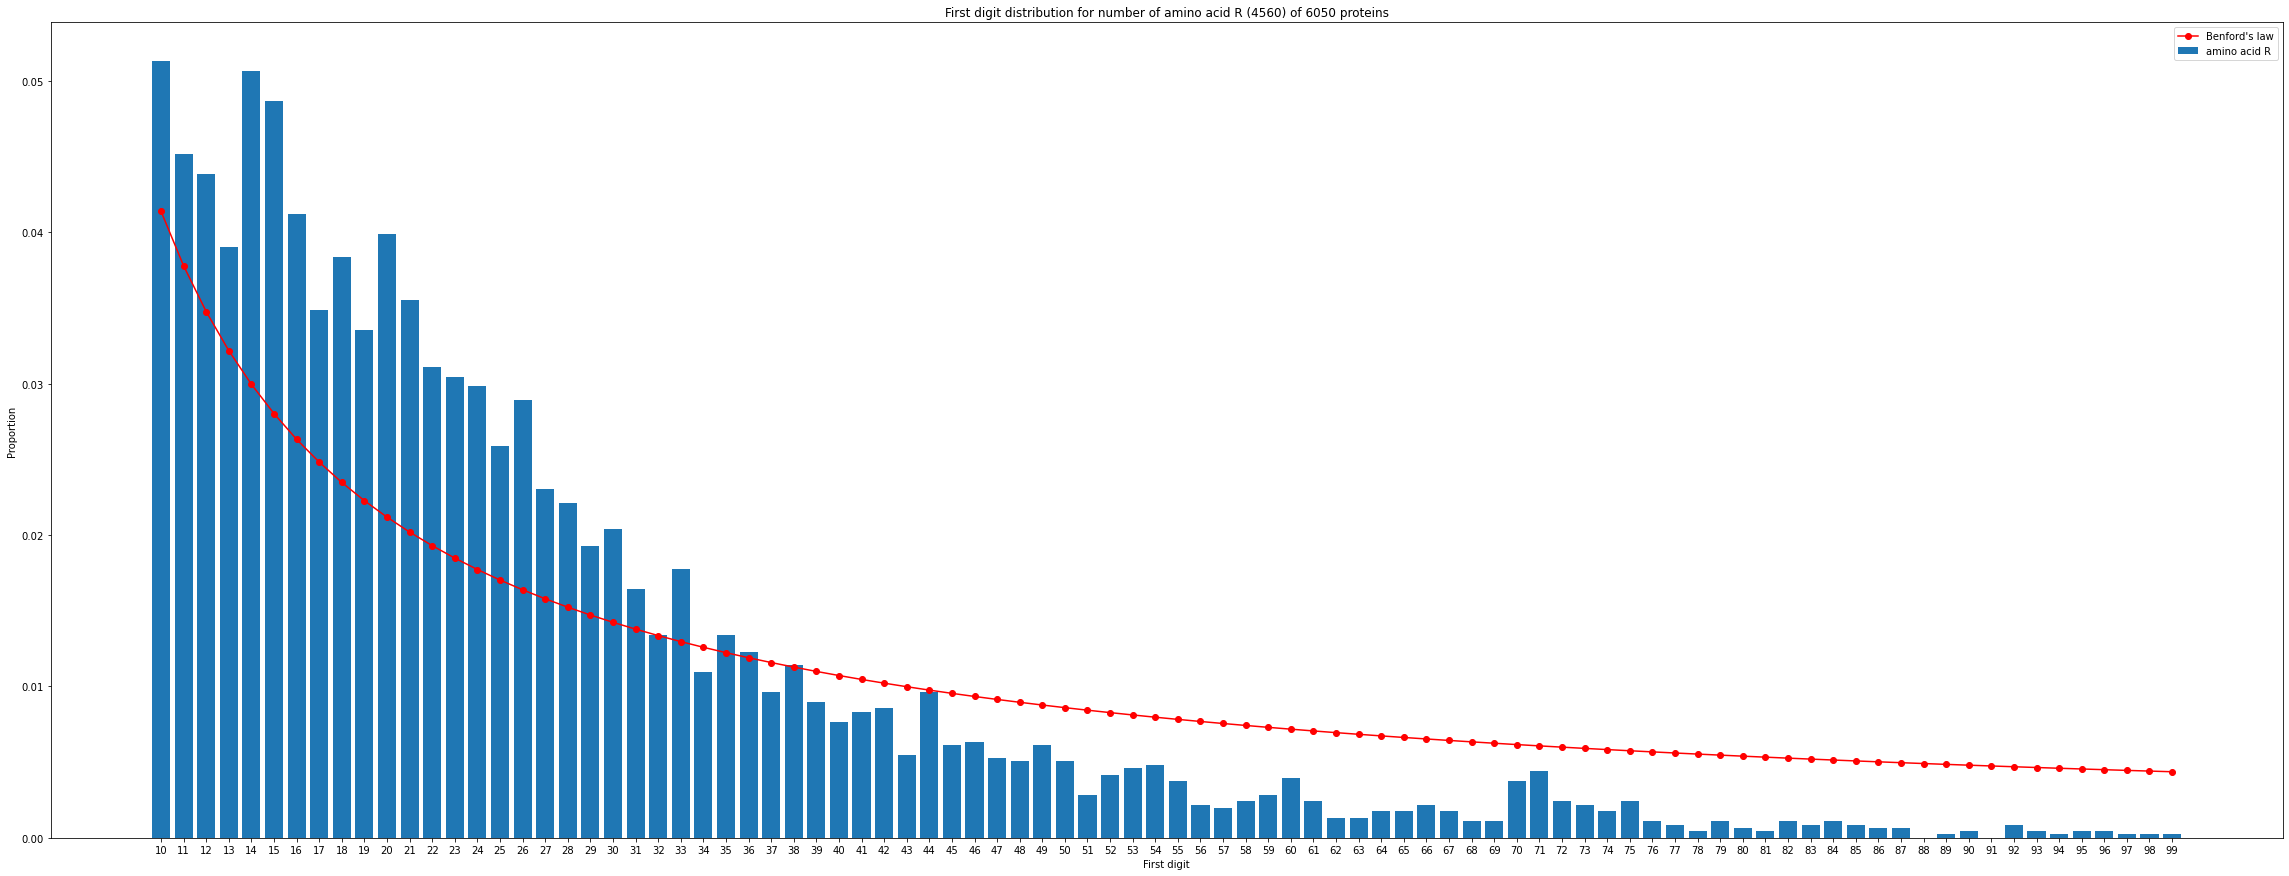

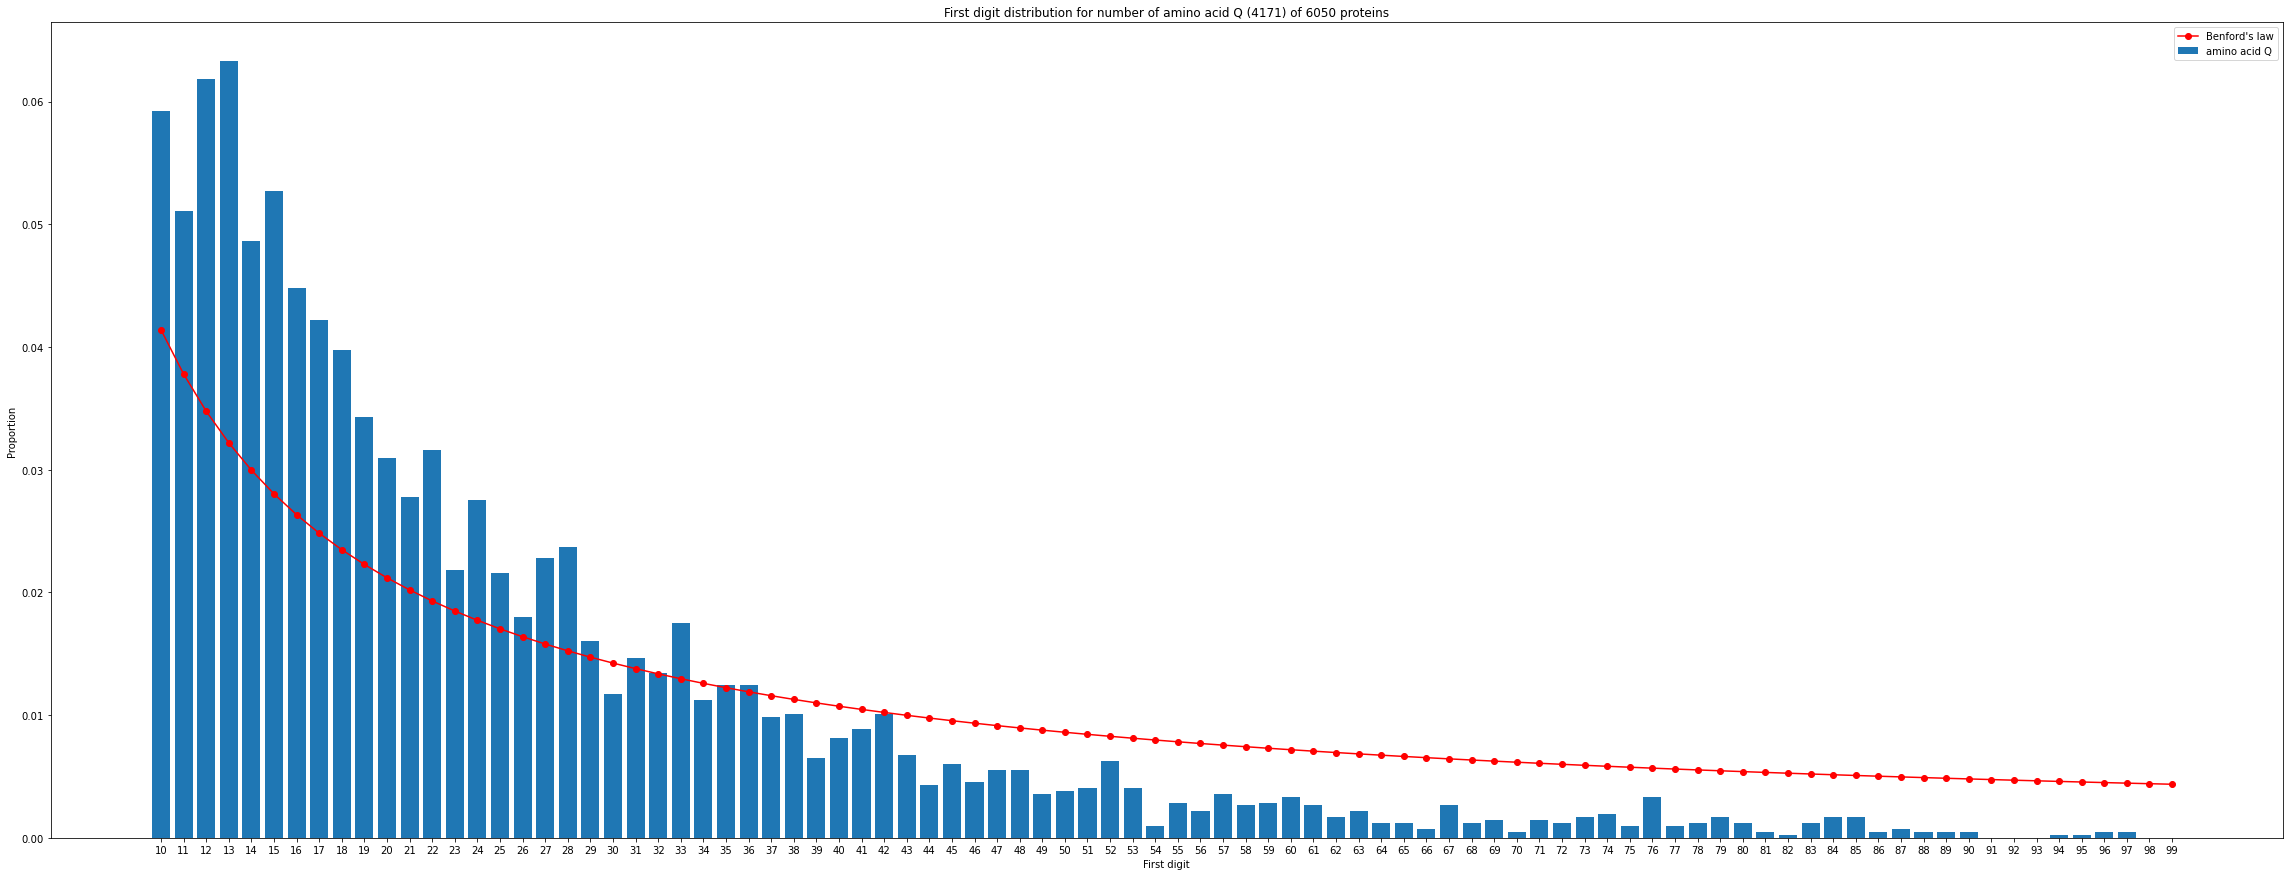

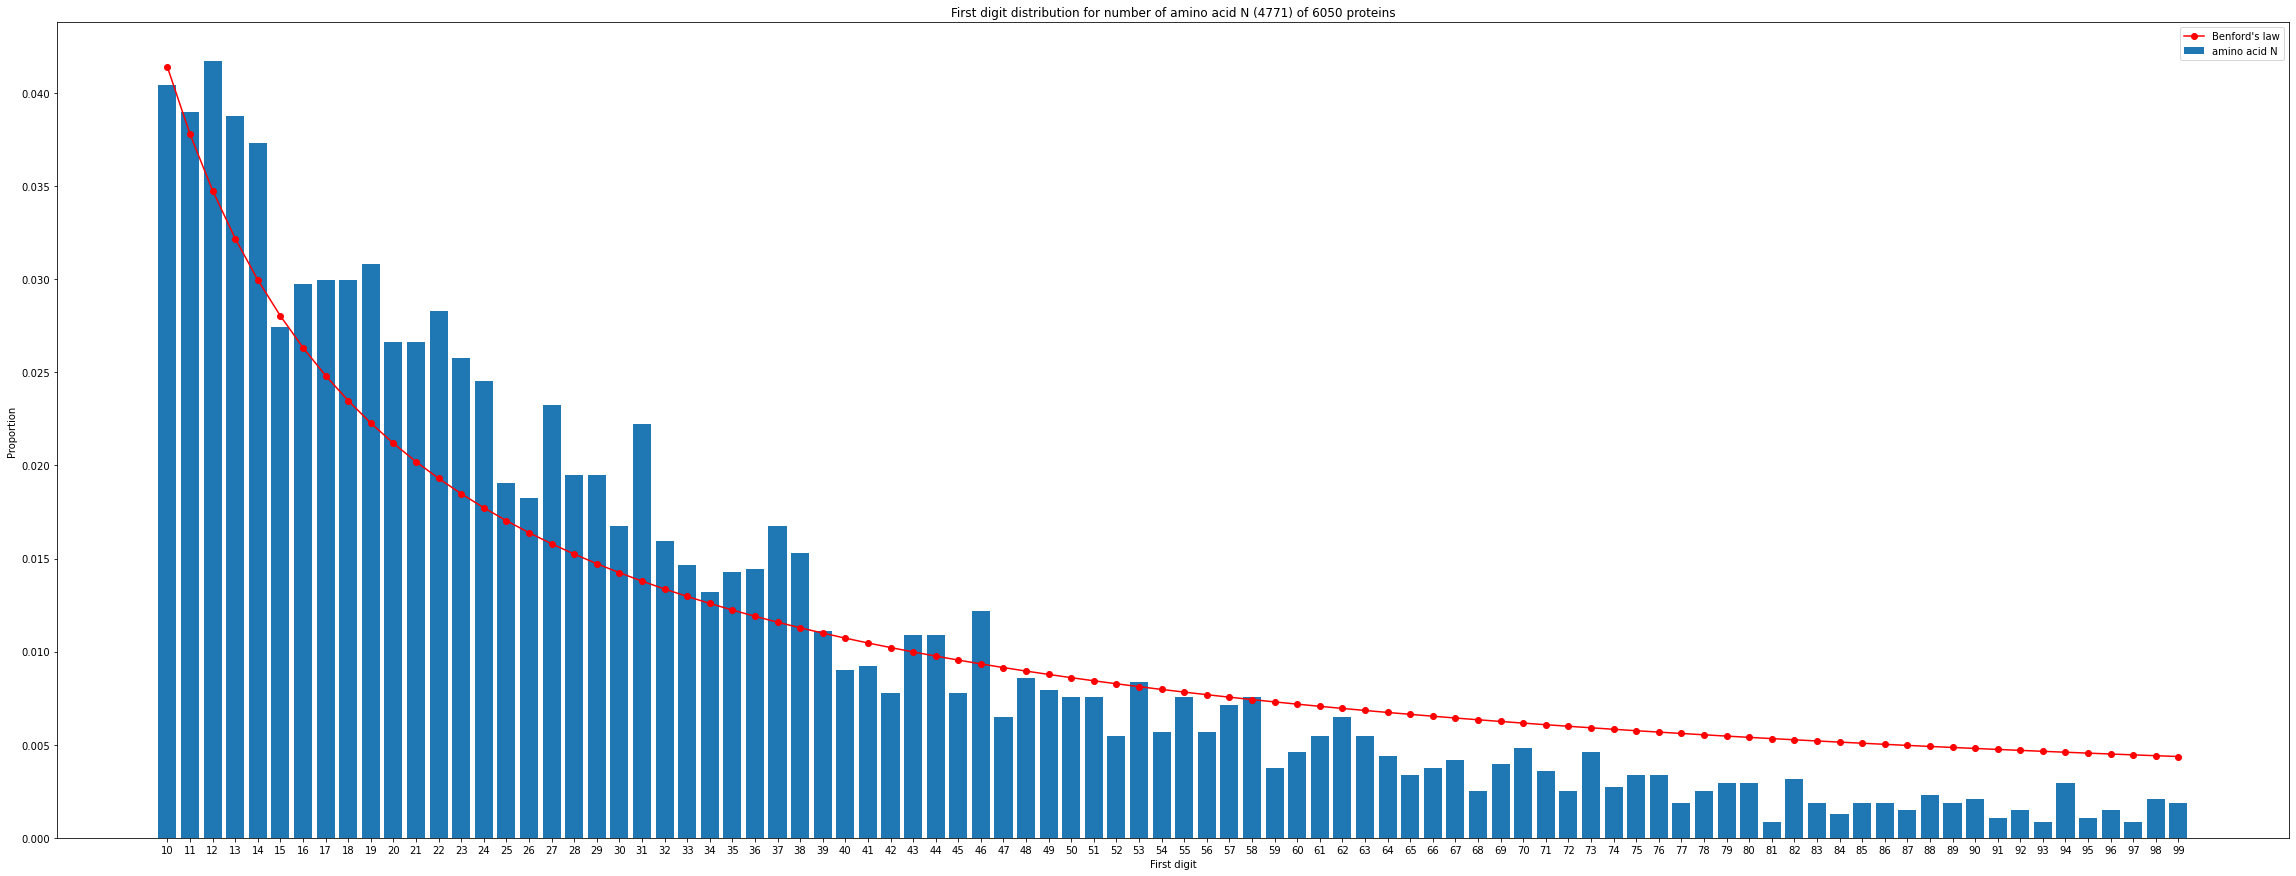

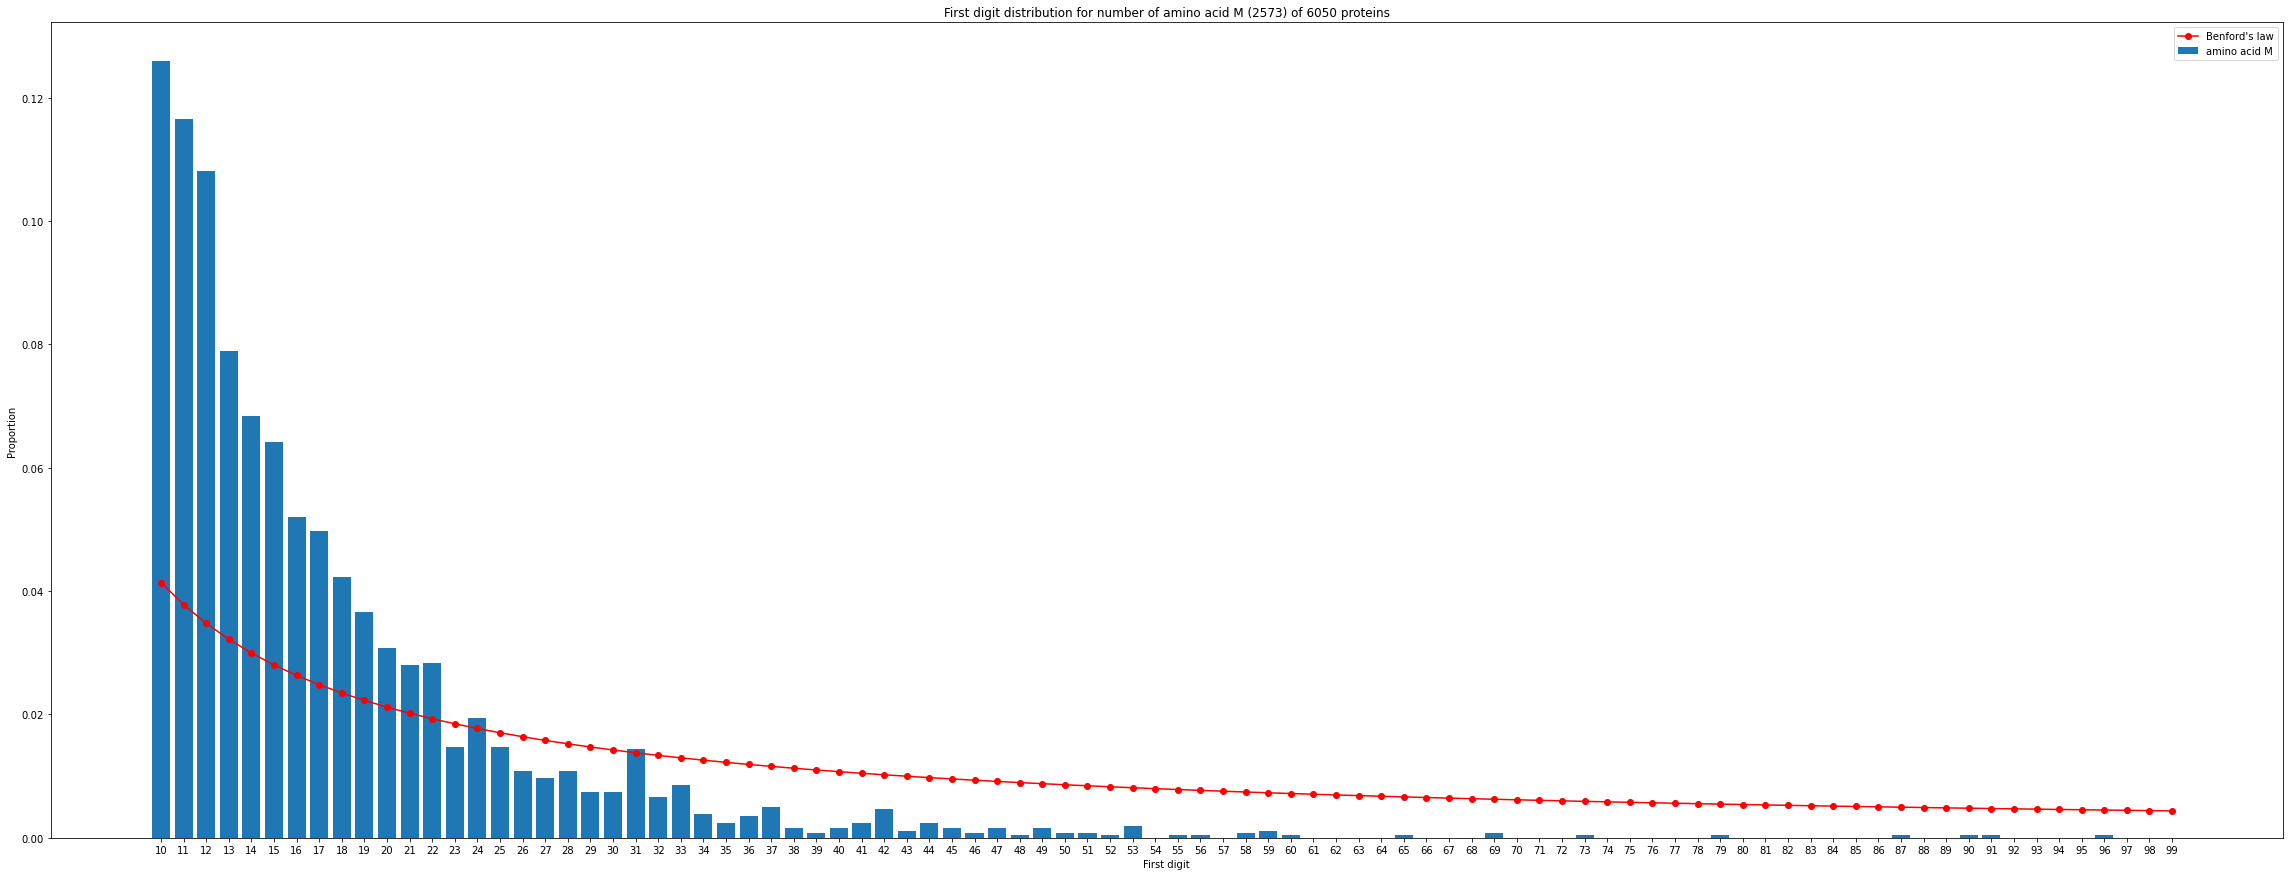

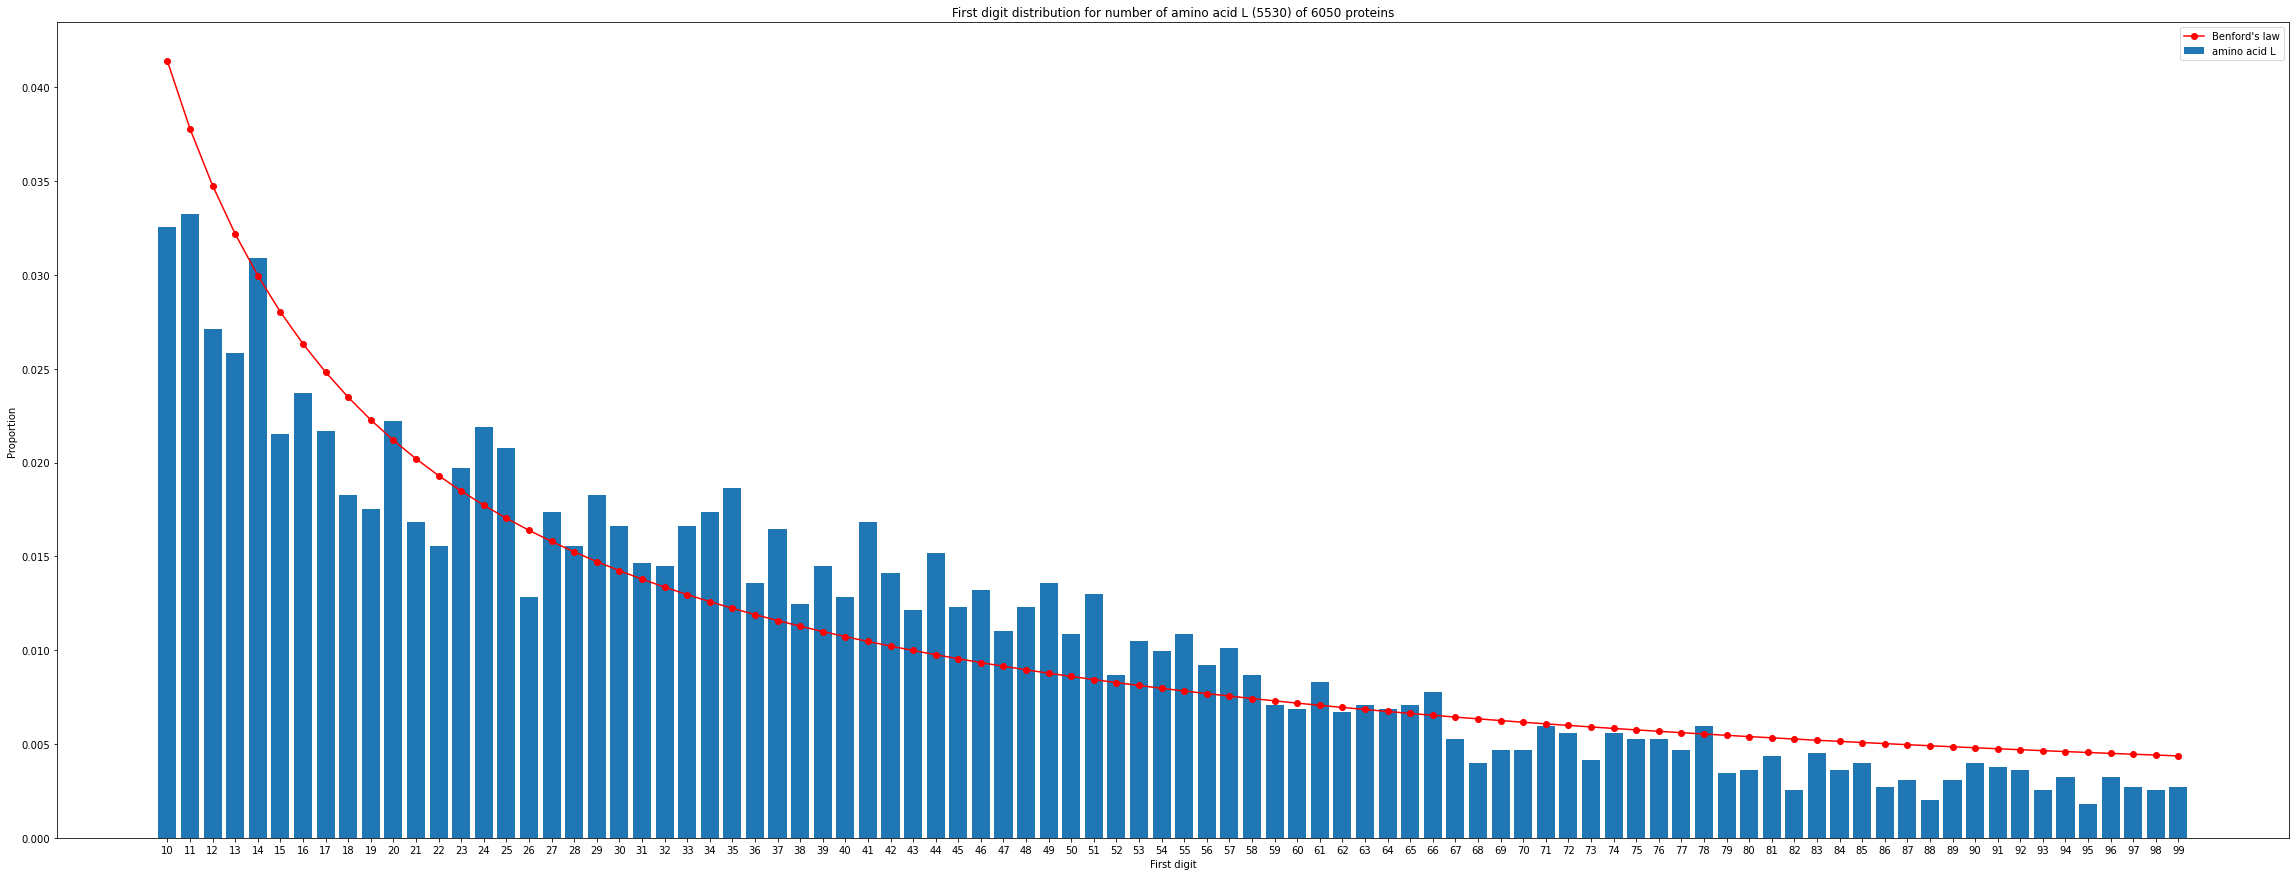

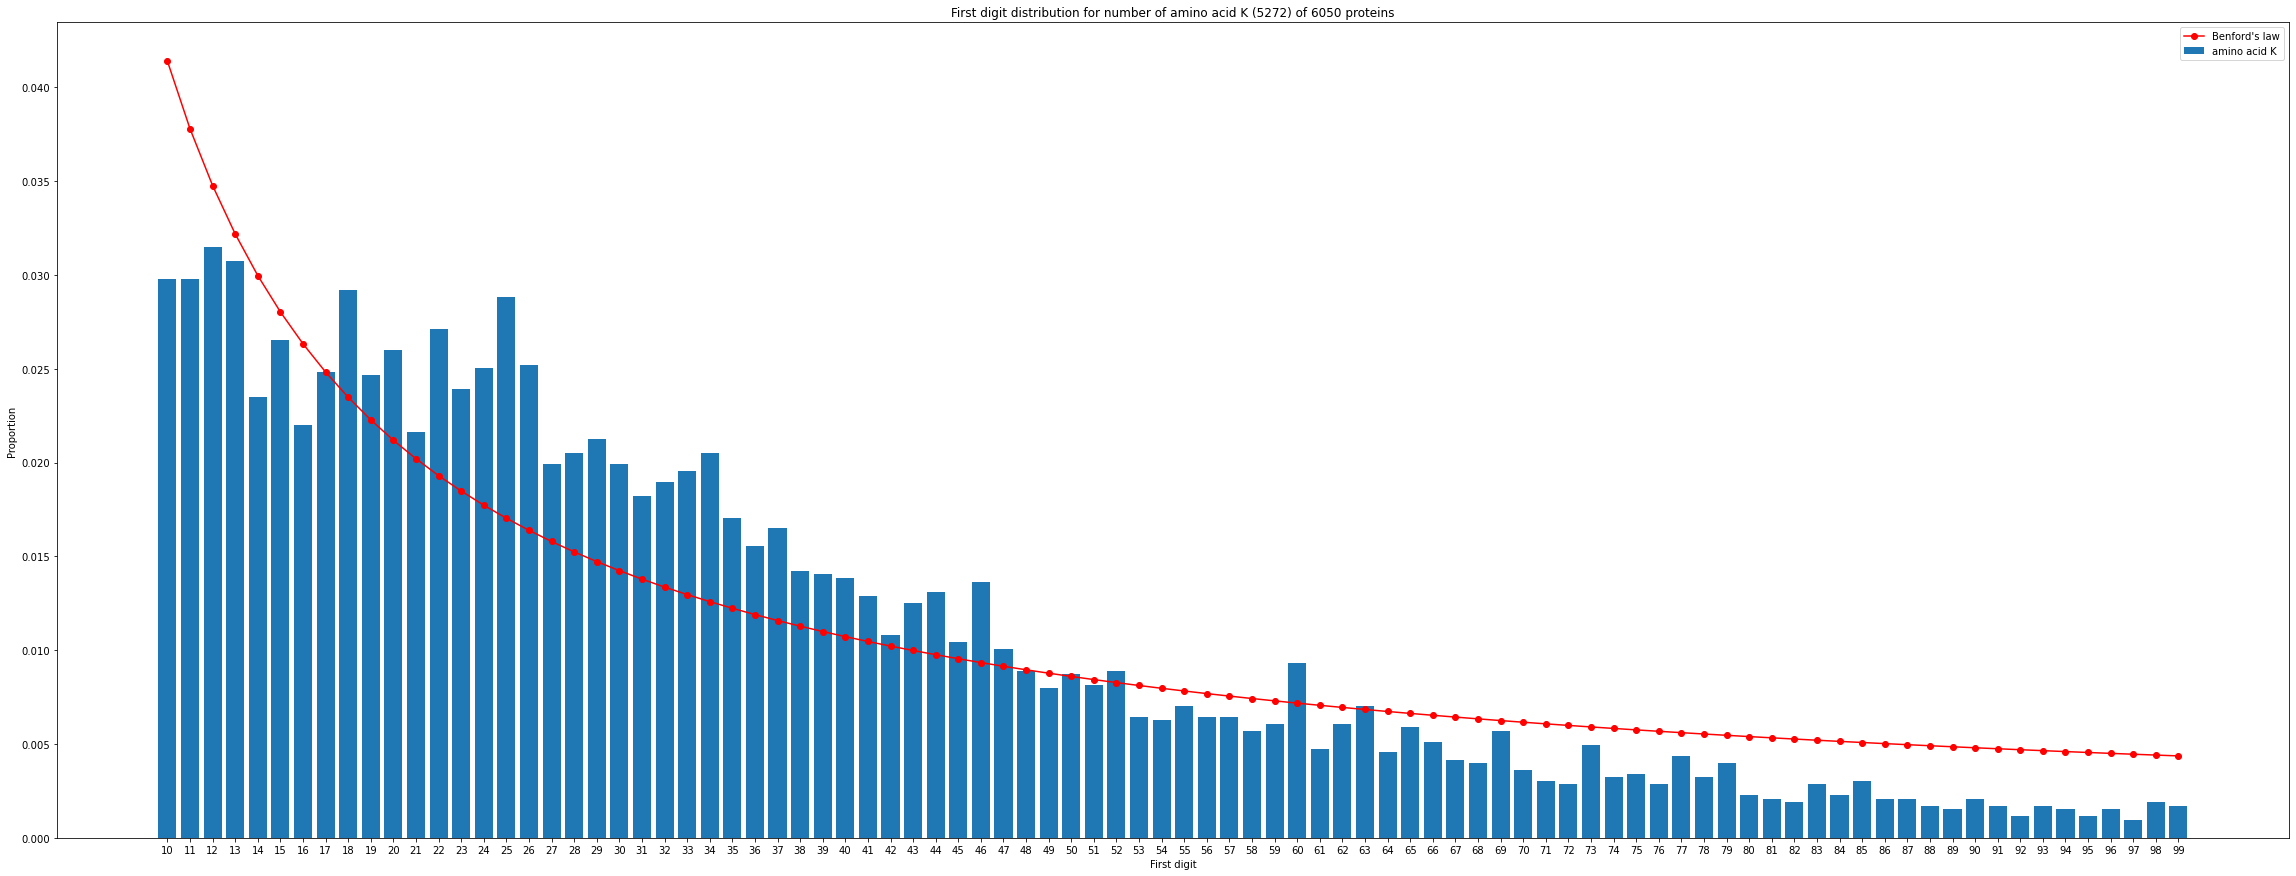

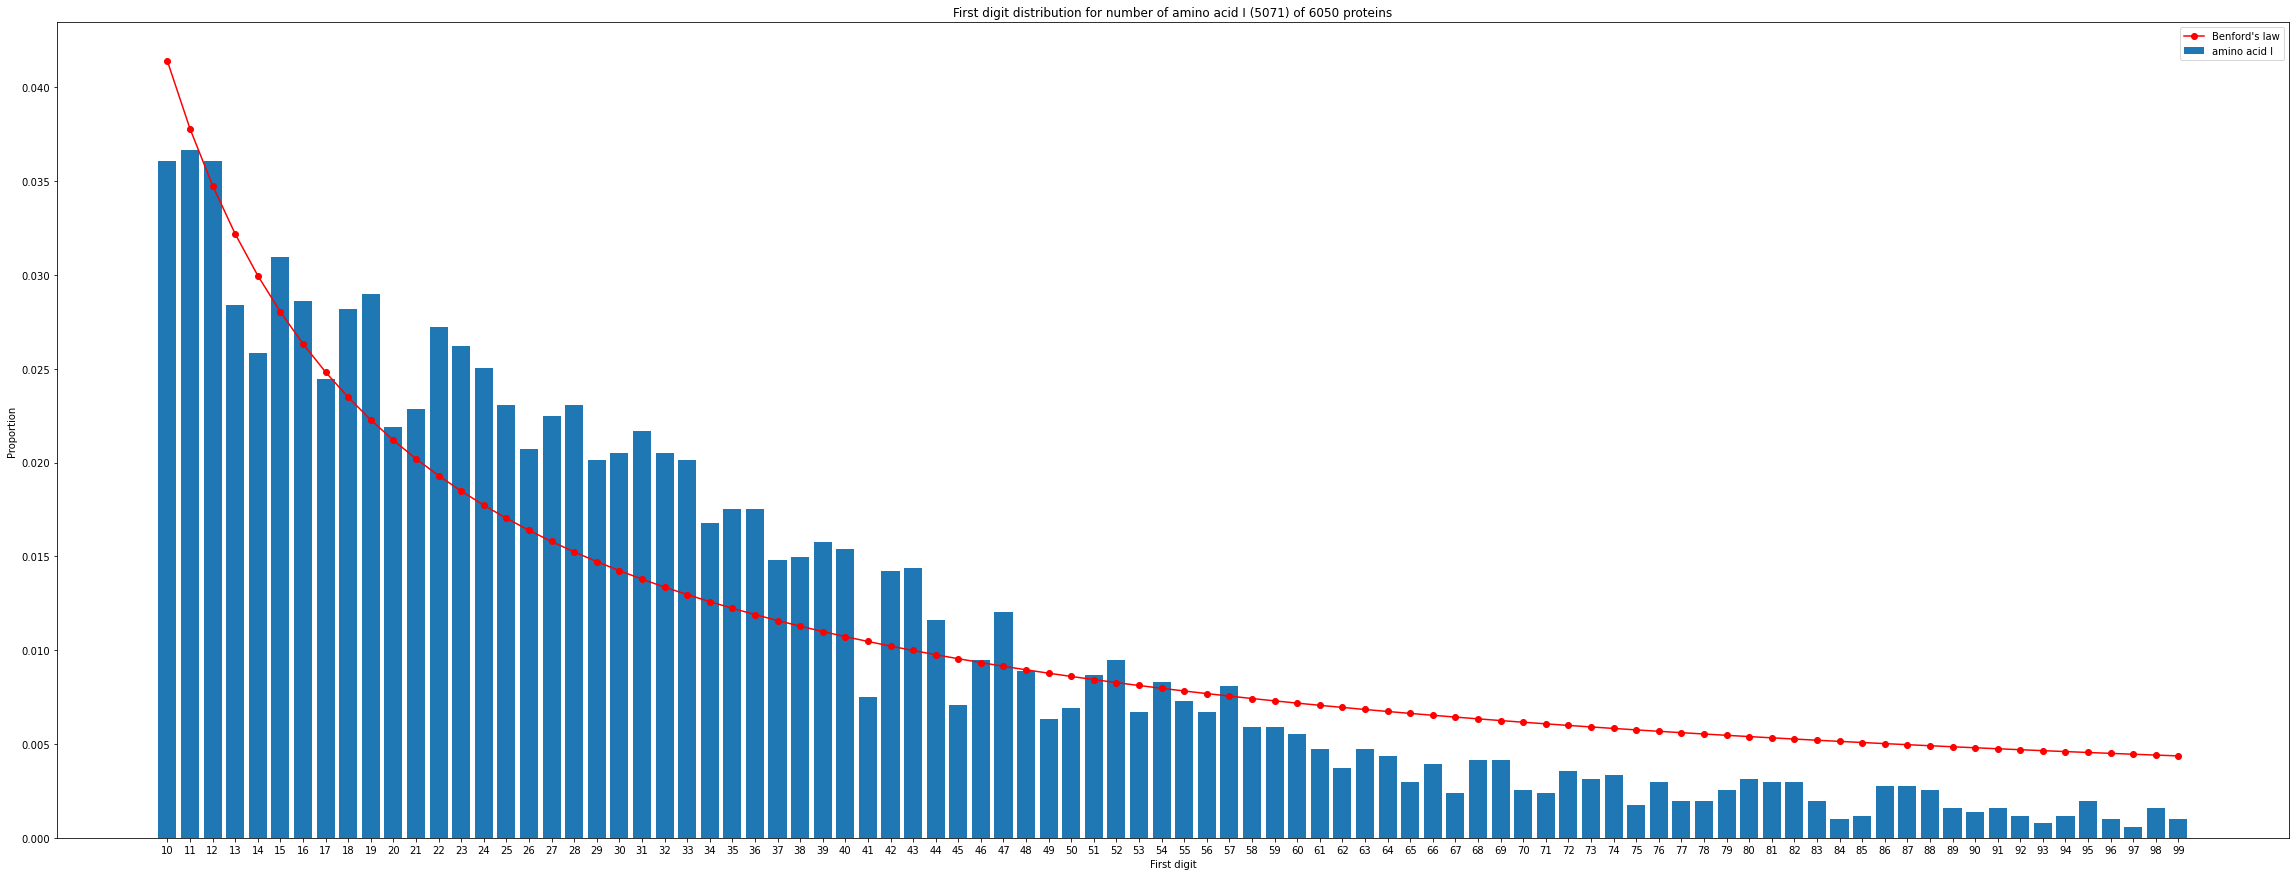

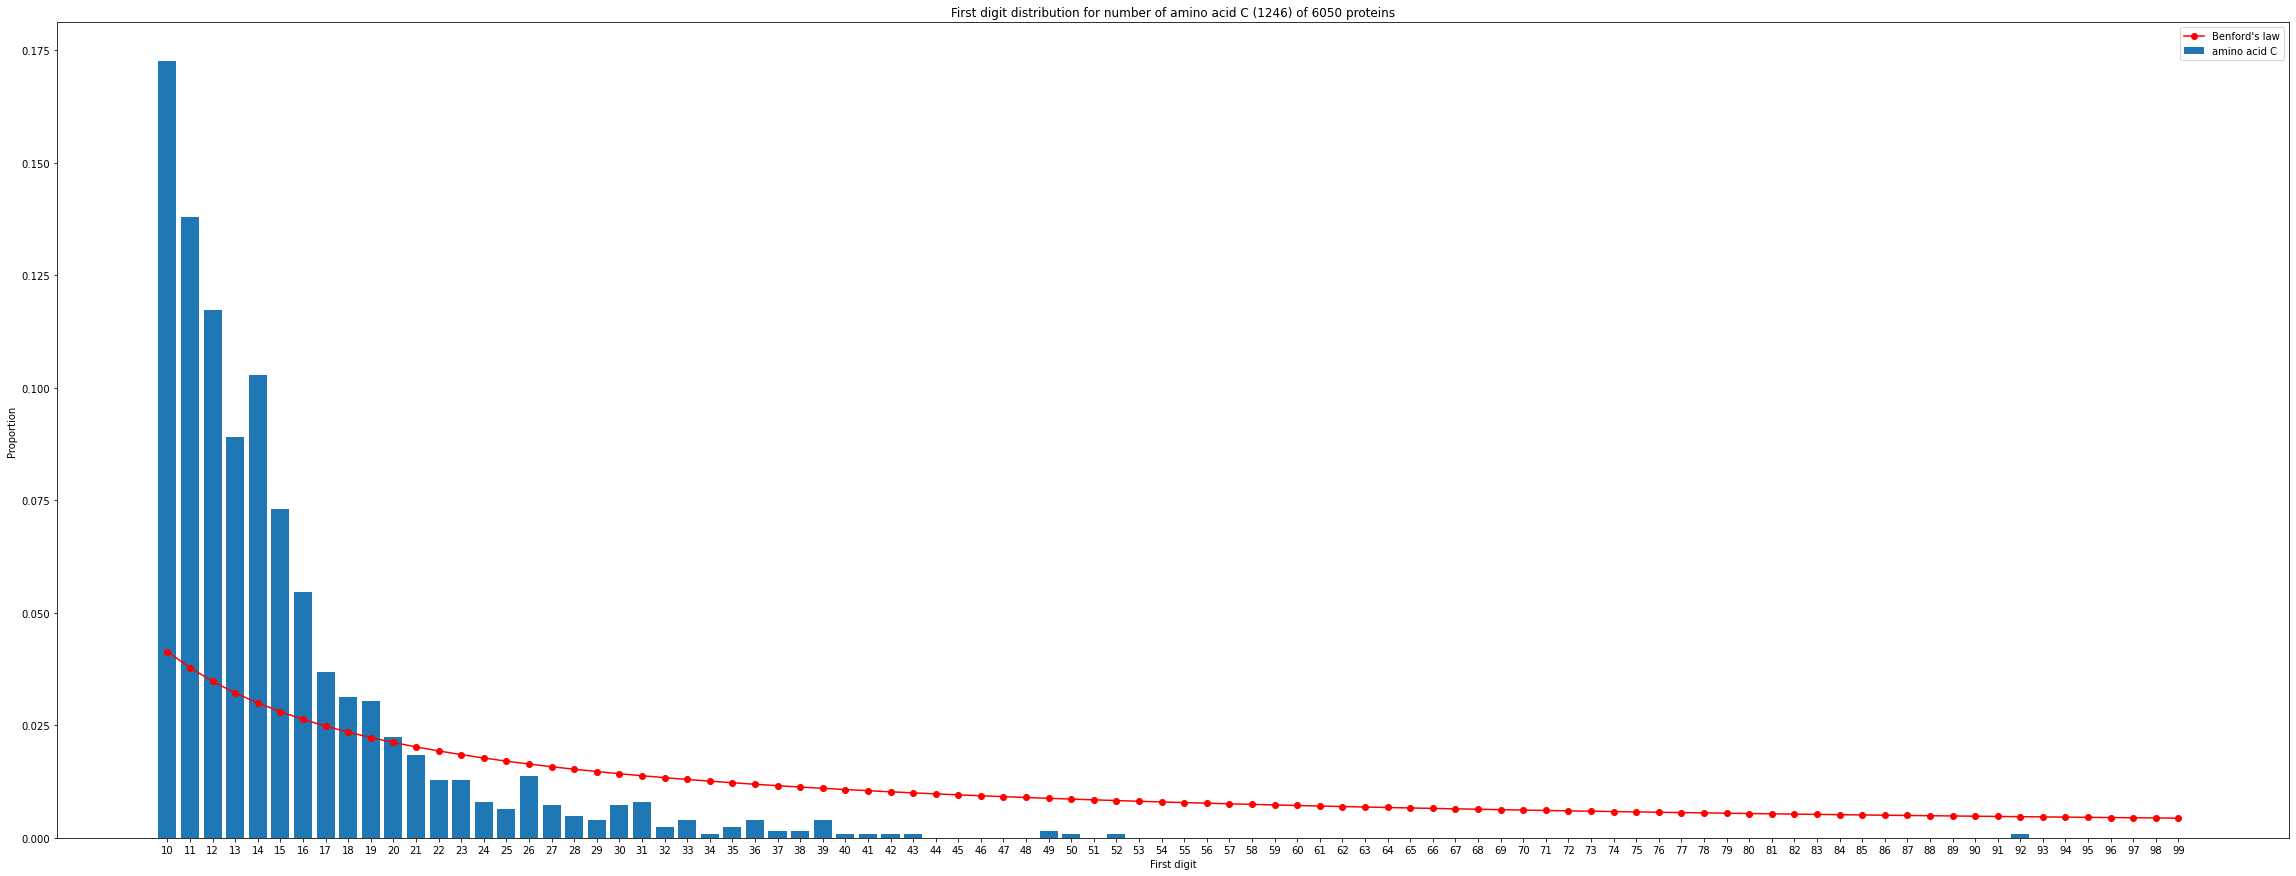

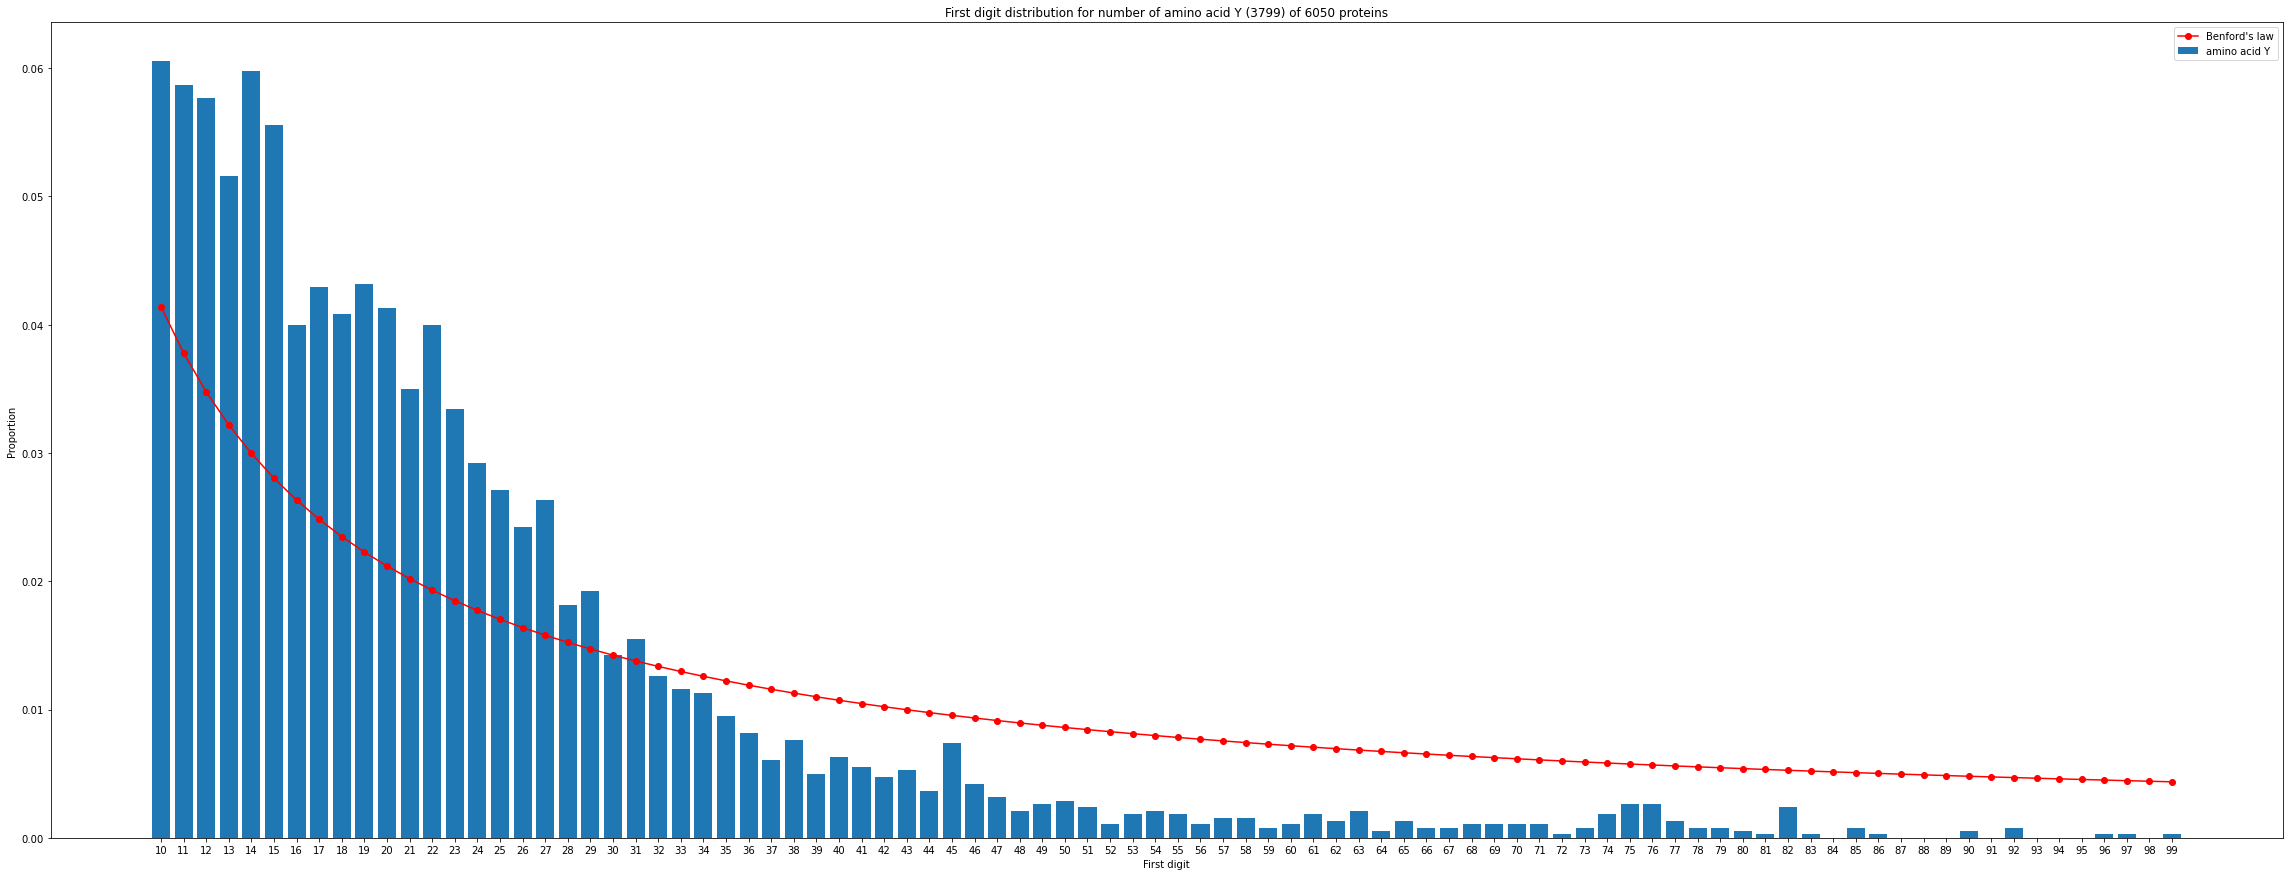

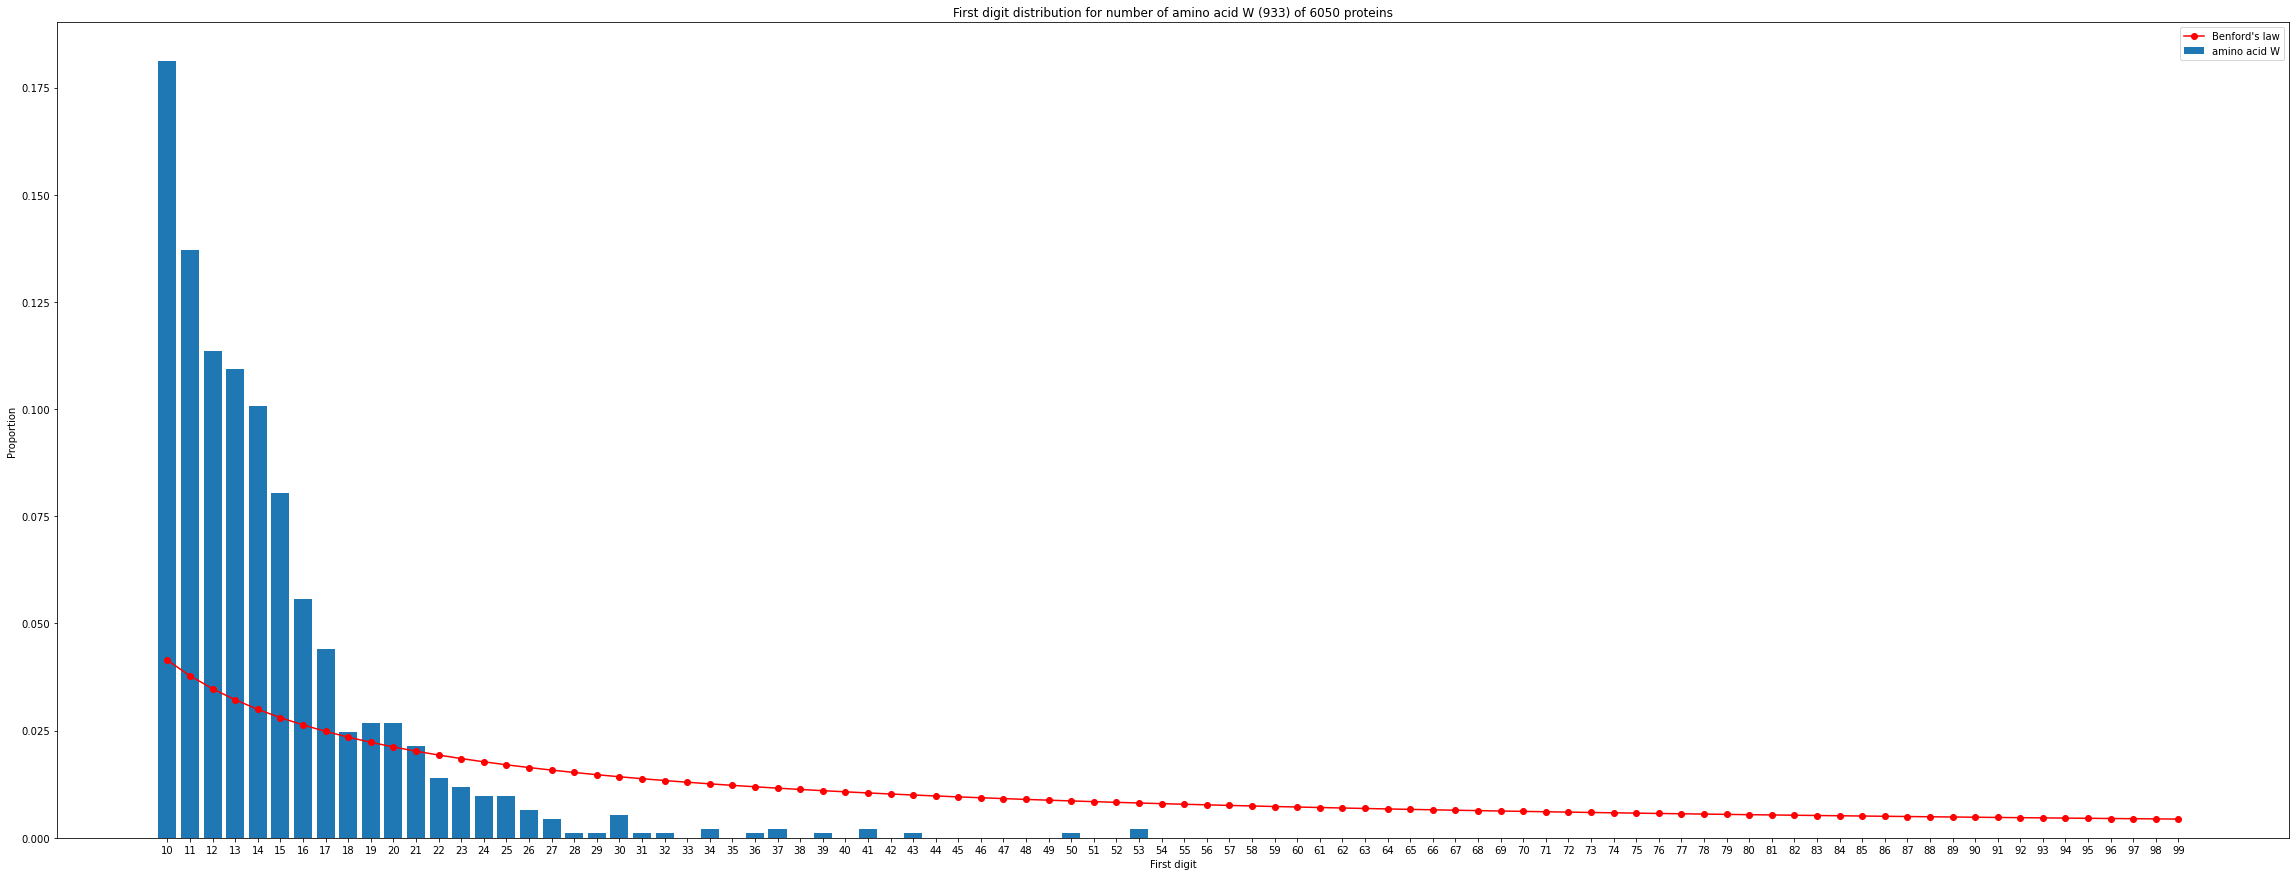

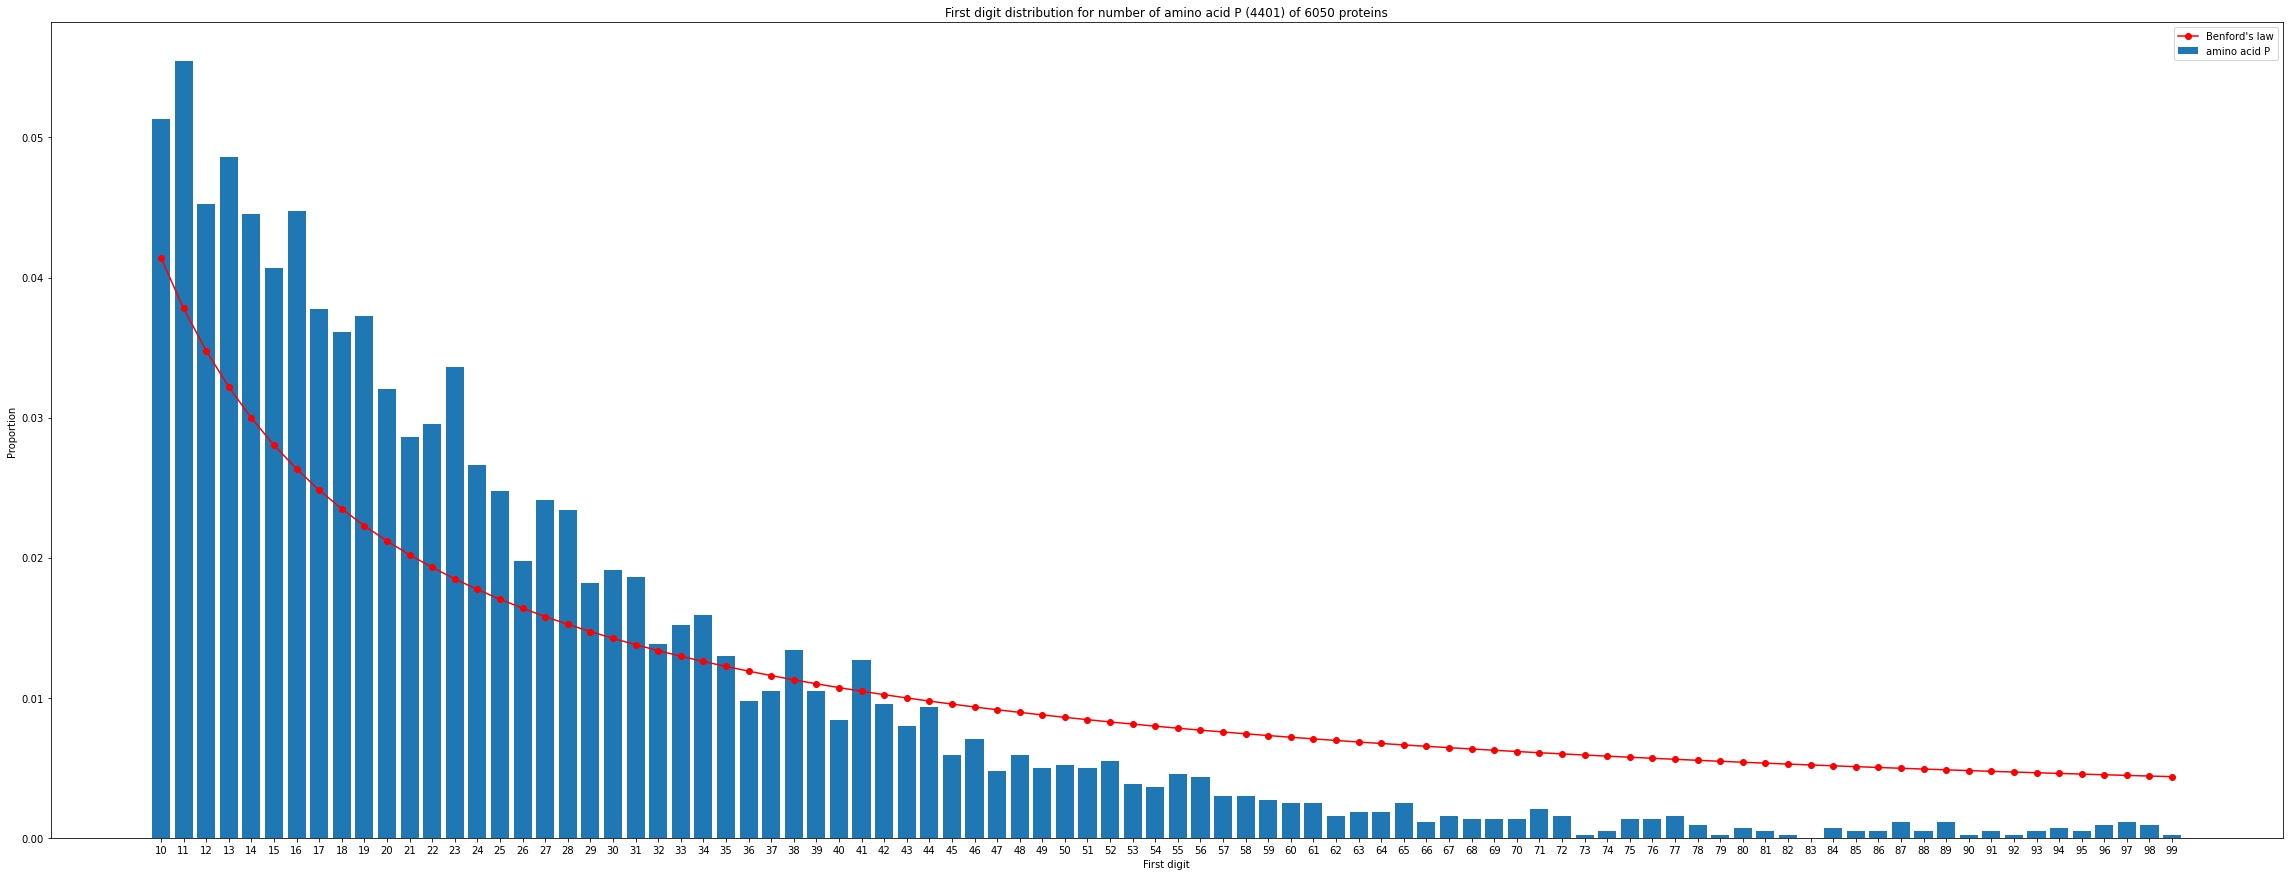

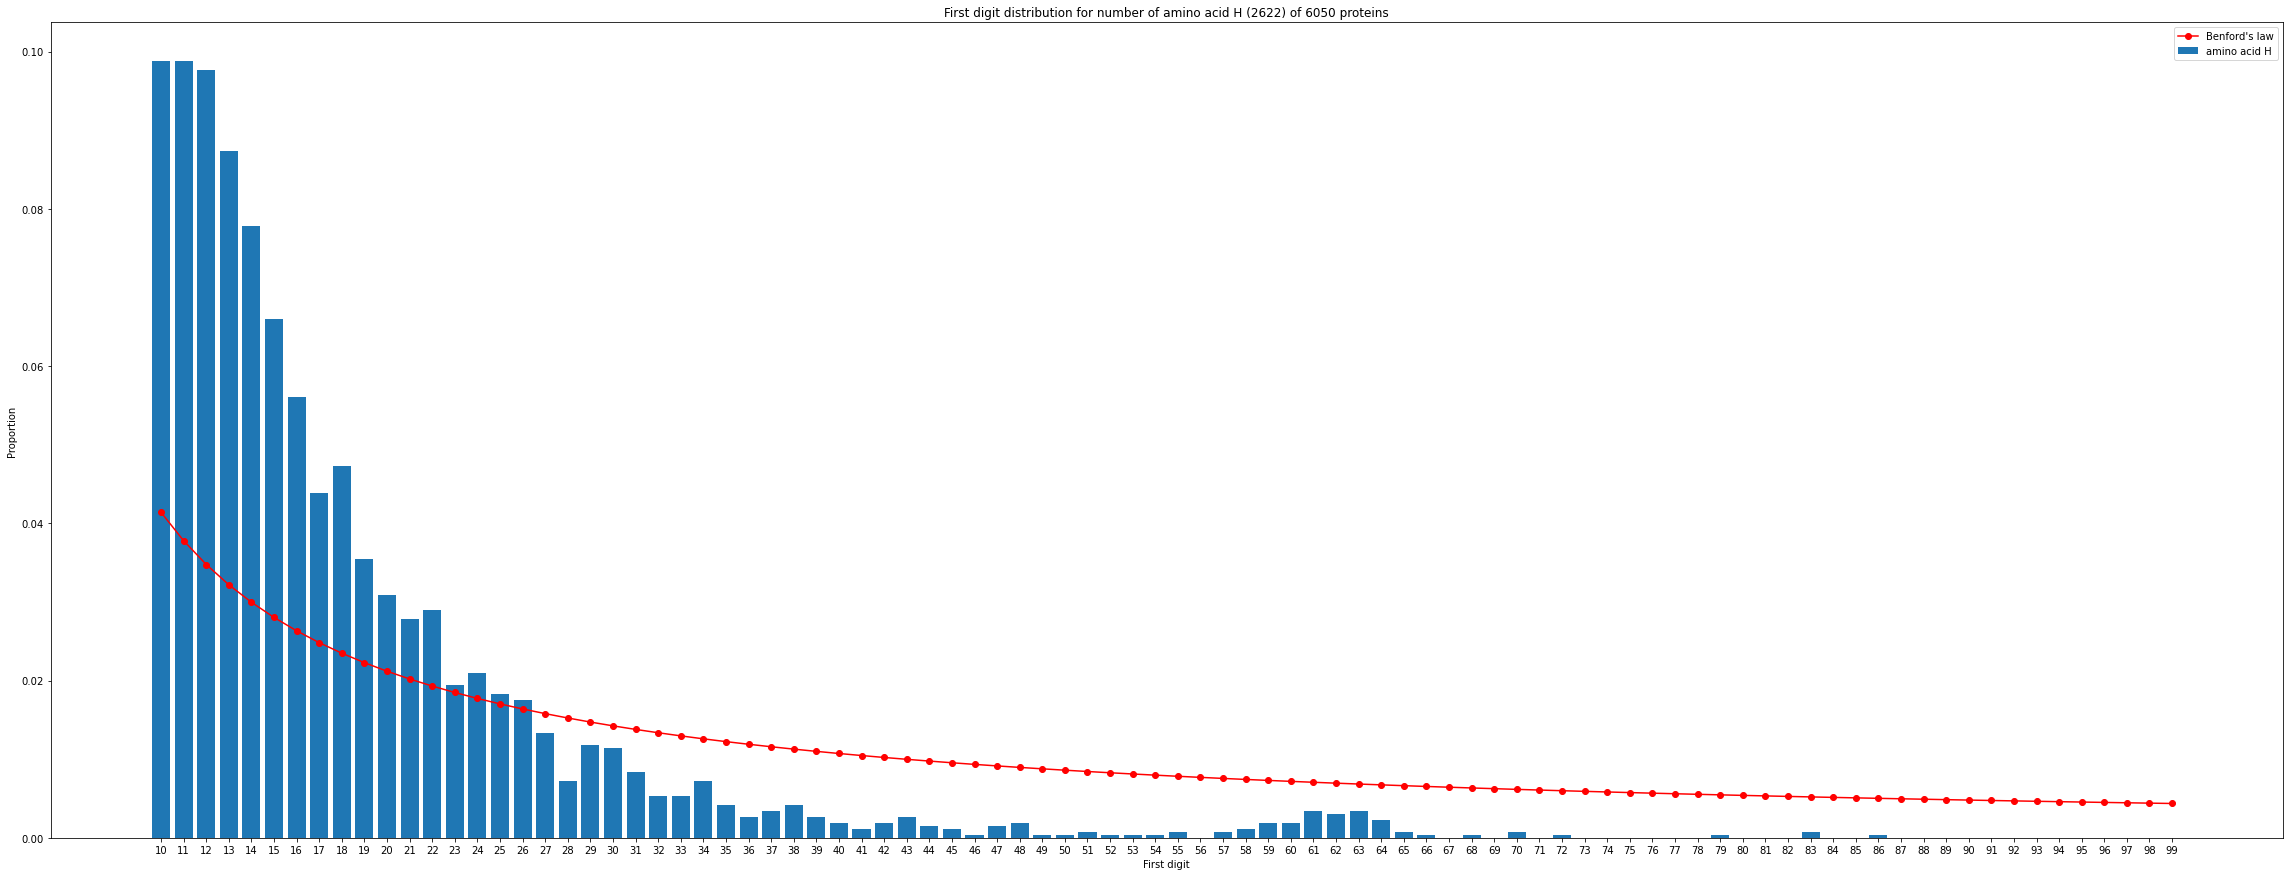

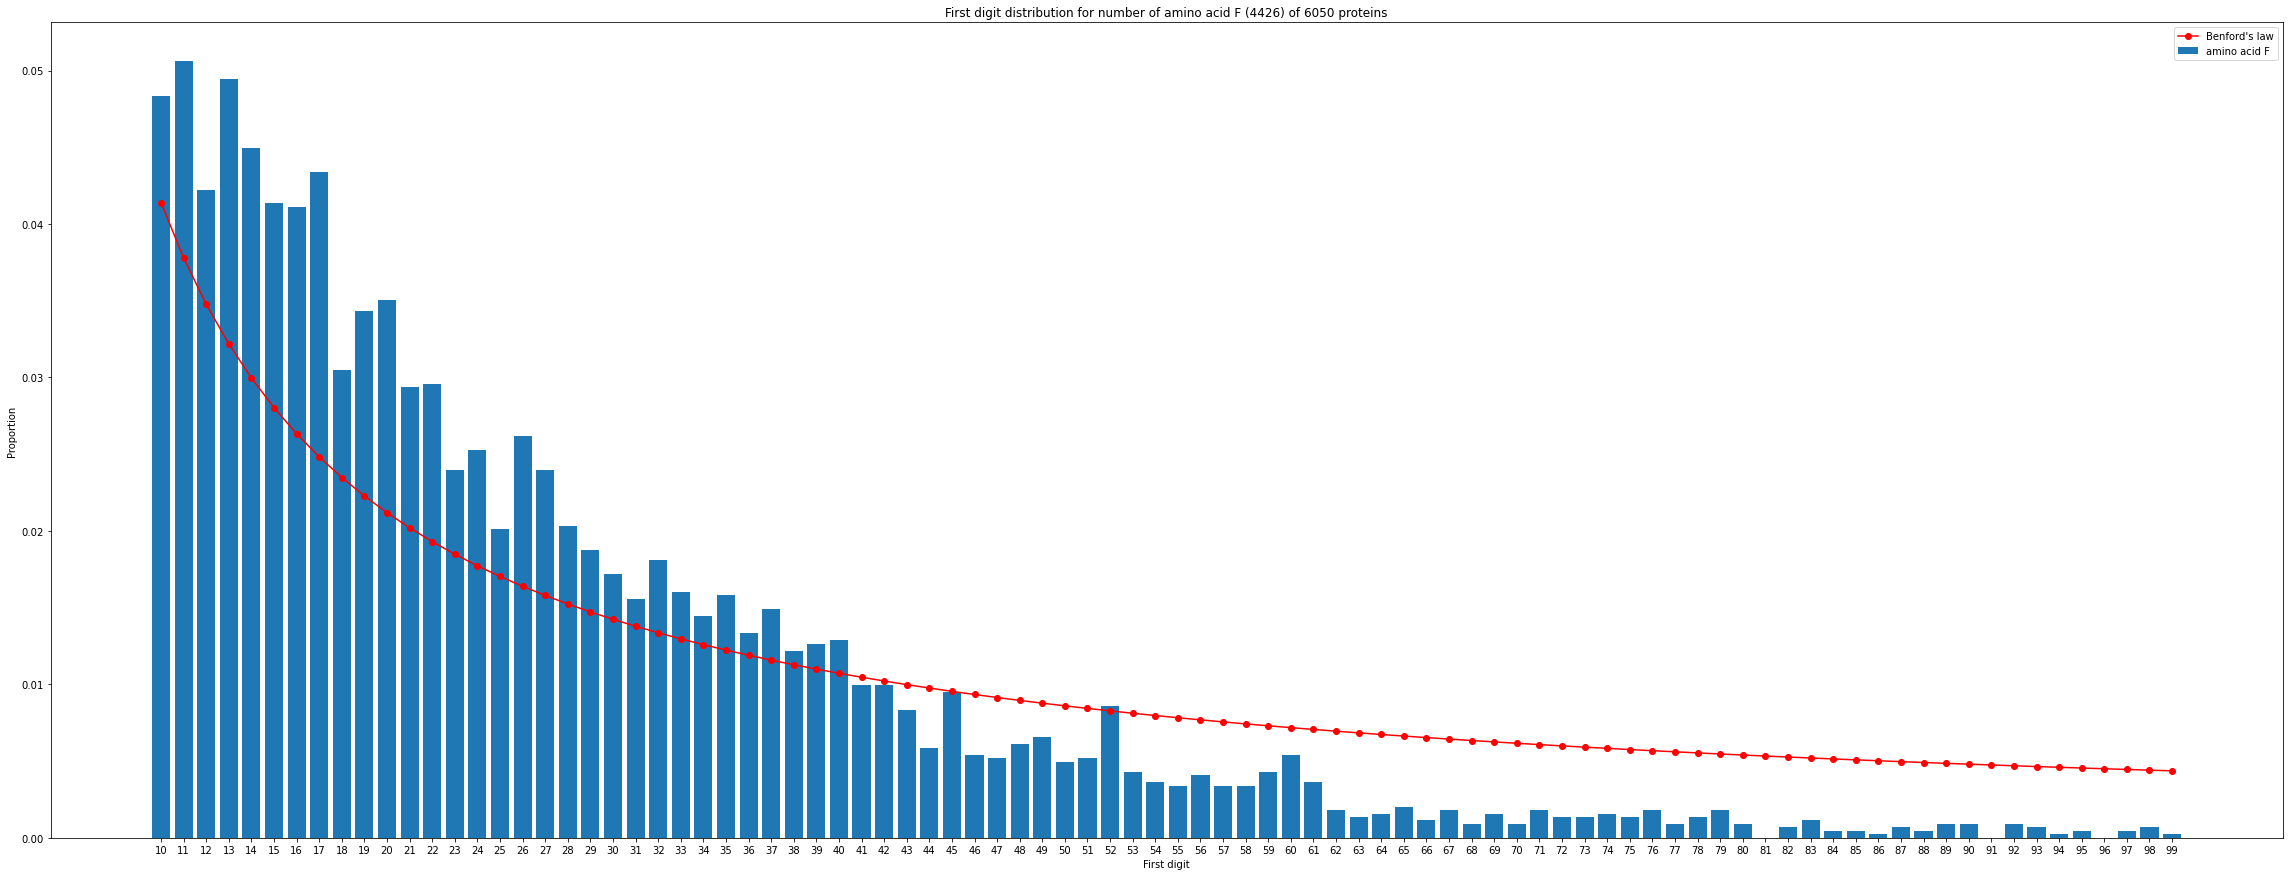

In [41]:
%%time
for aa in amino_acid:
    first_digit_aa = ben.count_first_digit(dict_aa[aa], 2)
    freq_aa = ben.normalize_first_digit(first_digit_aa)

    ben.build_hist_freq_ben(freq_aa, freq_theo2, 2, title="First digit distribution for"
                        f" number of amino acid {aa} ({sum(first_digit_aa)}) of "
                        f"{len(proteins)} proteins",
                            legend=f"amino acid {aa}", size=(40,15))
    print(f"results boostrap chisquare test of amino acid {aa} :")
    ben.calculate_bootstrap_chi2(dict_aa[aa], freq_theo2, 2)
    print(f"results boostrap K-S test of amino acid {aa} :")
    ben.calculate_bootstrap_ks(dict_aa[aa], freq_theo2, 2)

### Résultats
Graphiquement on remarque que le nombre d'acide aminé ne suit pas la loi de Benford pour les deux premiers digit.  

Aucun tests du $\chi^2$ n'est non-significatifs, la p-value obtenue pour ces tests sont tous inférieur à 5%. Concernant les test de K-S, certains sont non-significatifs alors que les test du $\chi^2$ ne le sont pas. Cela remets en doute l'éfficacité de ce test. On peut donc conclure que le nombre d'acide aminé ne suit pas la loi de Benford pour les deux premiers digit.

### Conclusion

Le nombre d'acide aminé par protéines d'un protéome ne suit pas la loi de Benford pour les deux premiers digit.